# AP-1 Peak Calling

In [19]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## C57Bl6 ChIPs

### Preprocessing

In [74]:
# file directories
workingDirectory = '/home/jtao/analysis/ap1_analysis/'
peakDirectory = '/home/jtao/analysis/ap1_analysis/peak_files/'
scratchDirectory = '/home/jtao/analysis/ap1_analysis/scratch'
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories/'

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(tagDirPath)):
    logFile = [x for x in os.listdir(tagDirPath + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(tagDirPath + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:122: FutureWarning: sort(....) is deprecated, use sort_index(.....)


### Mapping Quality Control

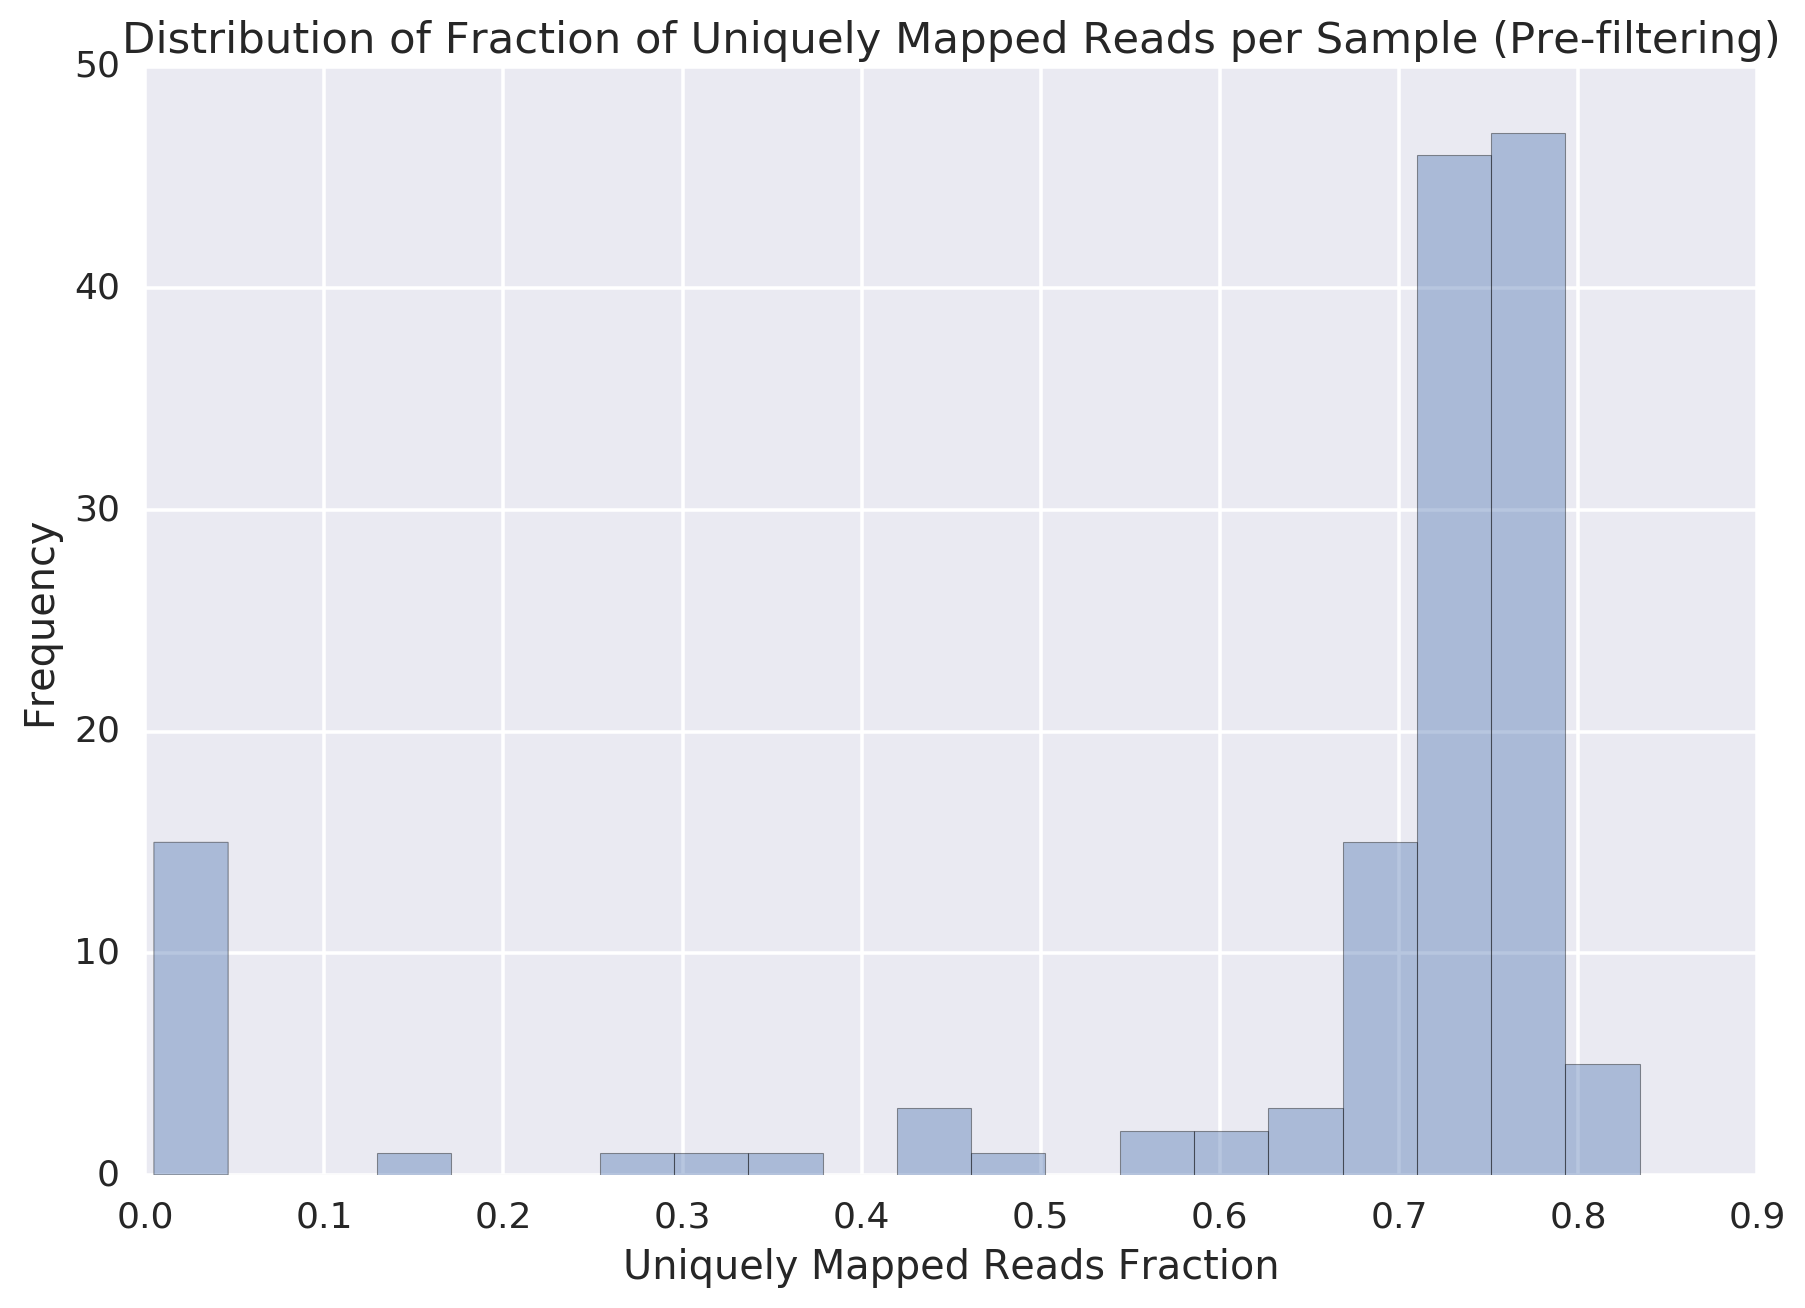

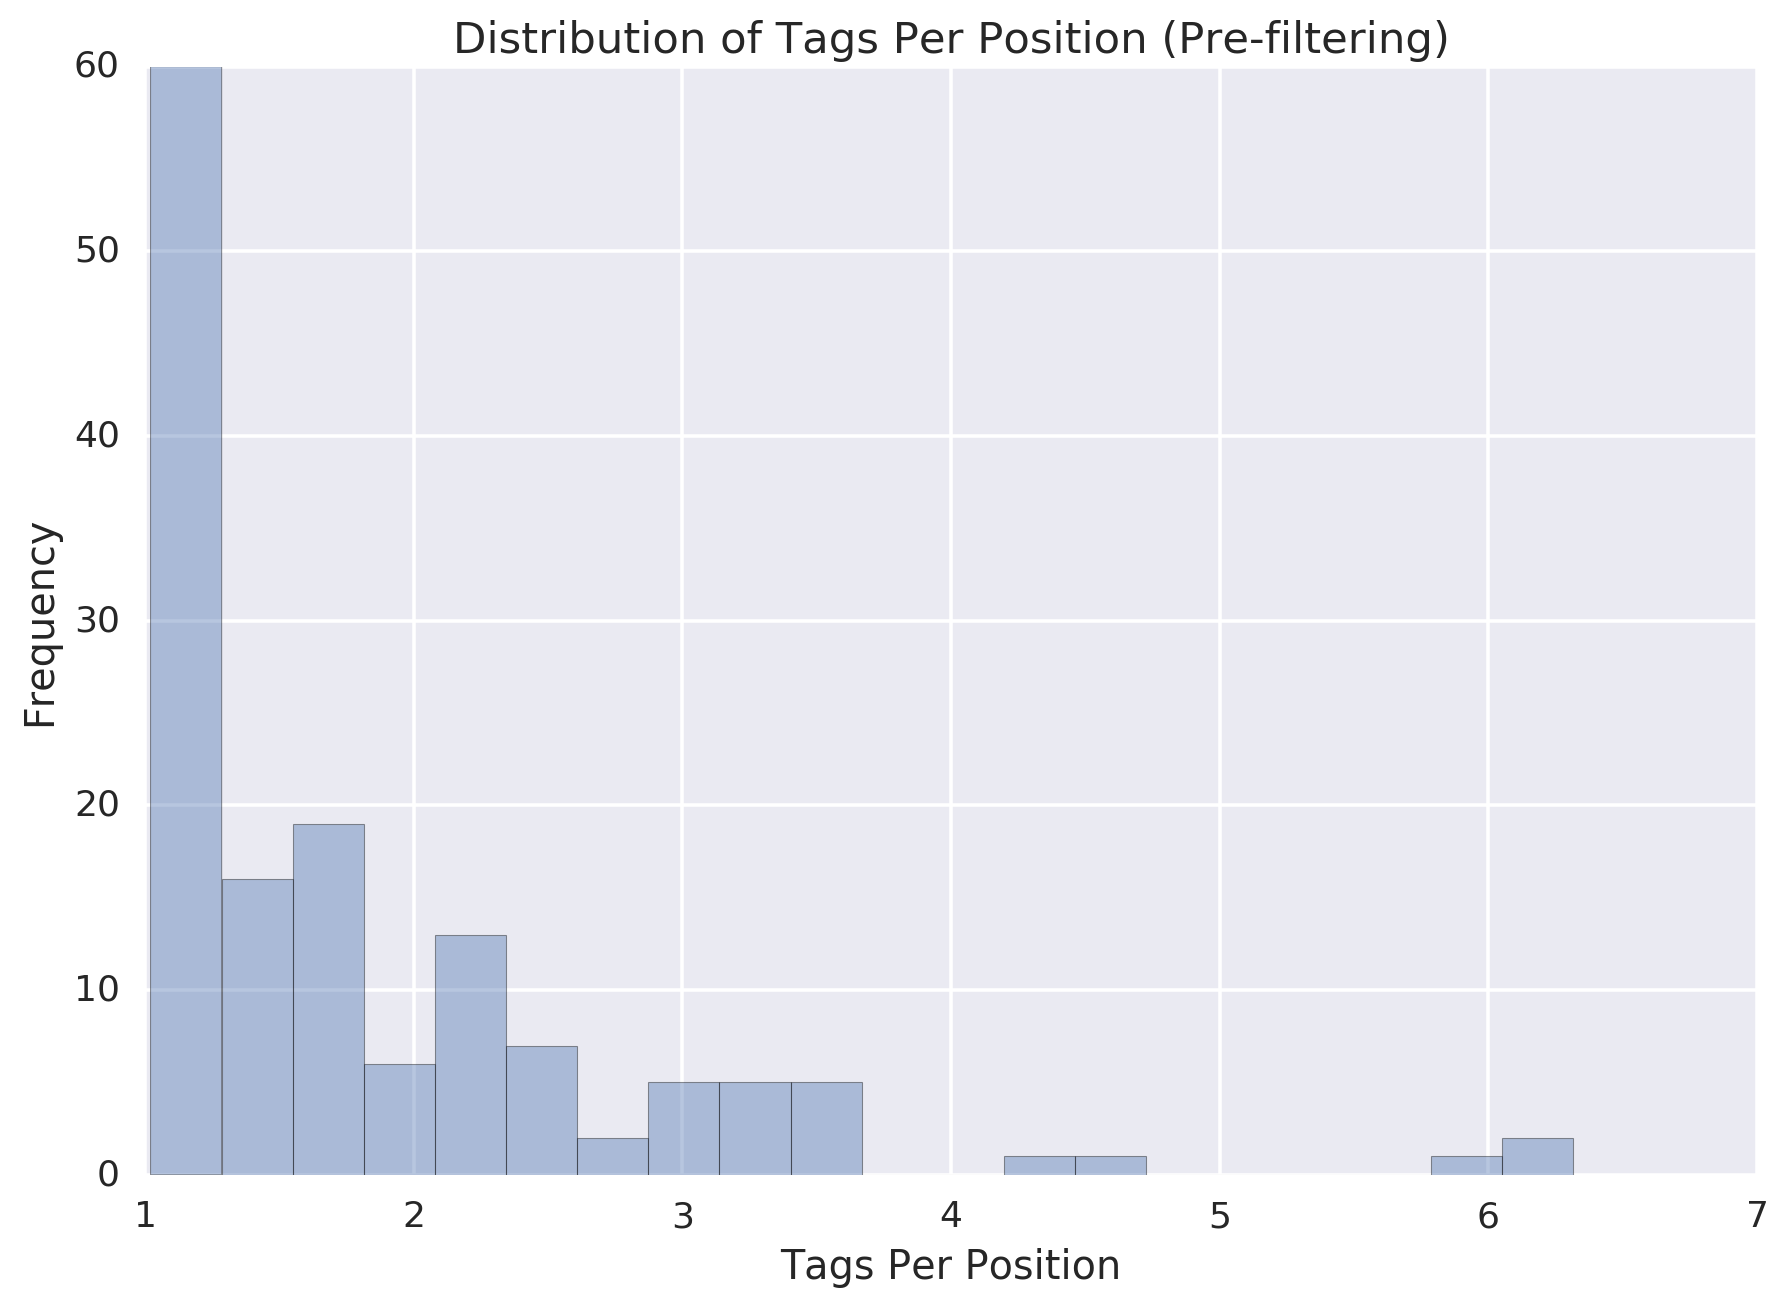

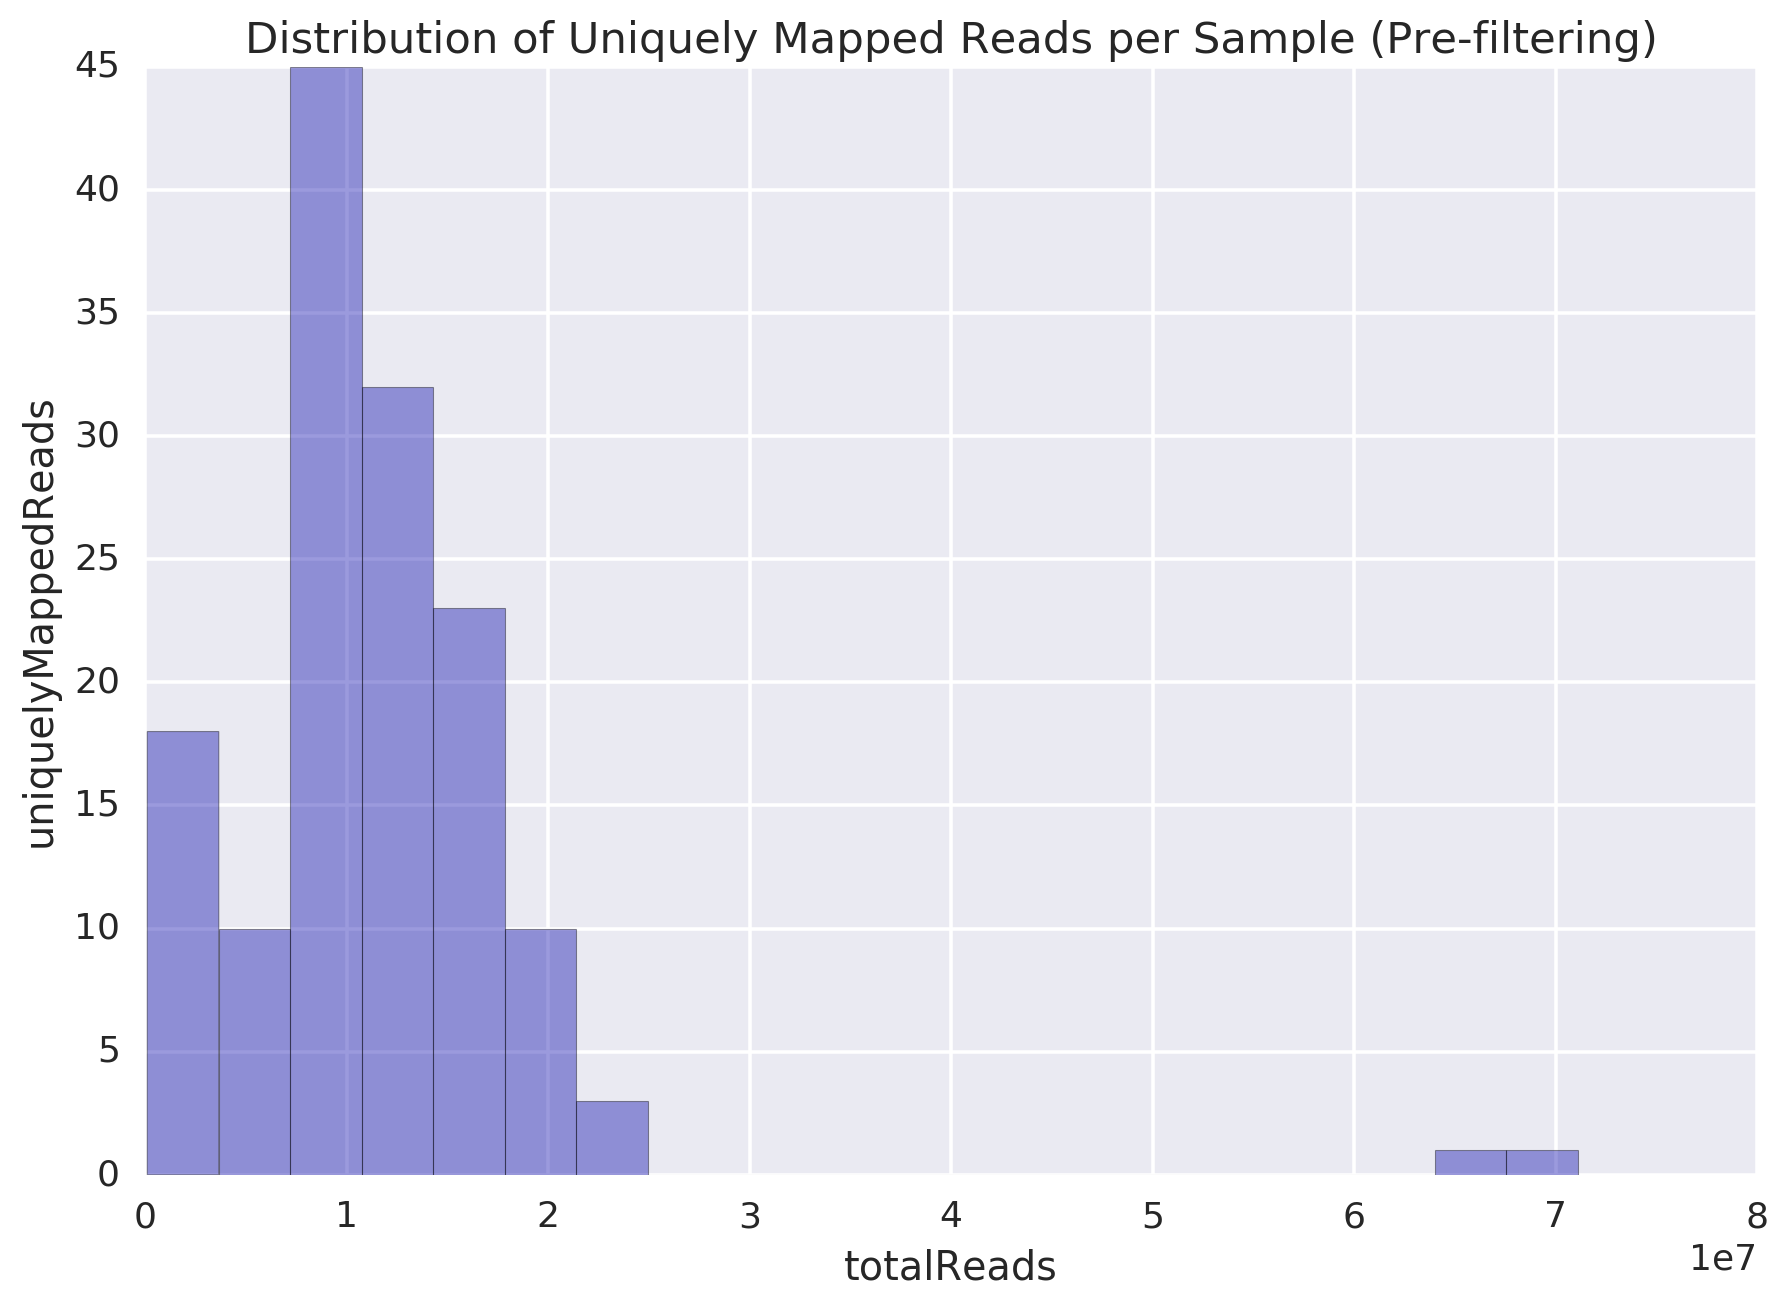

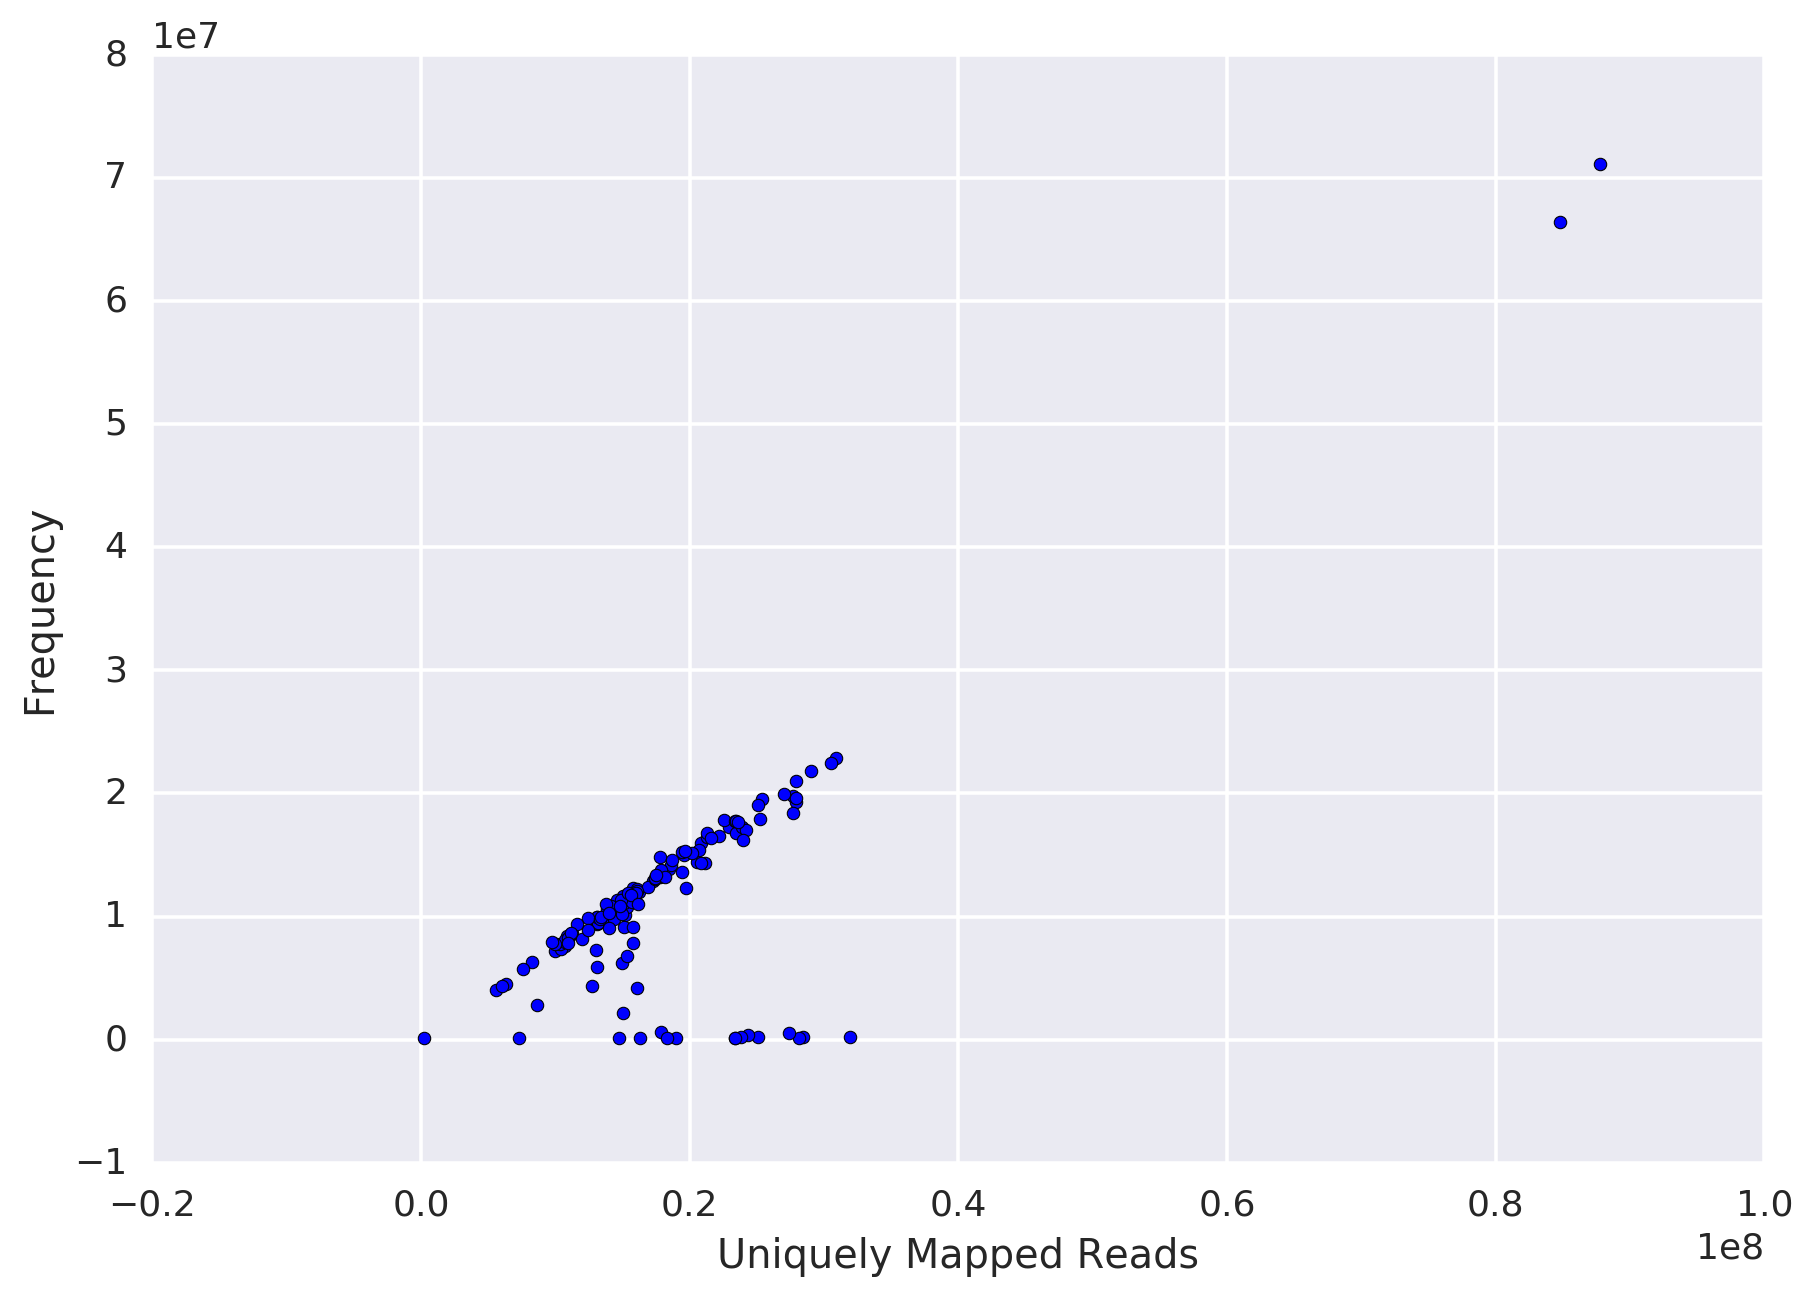

In [75]:
# plot distribution of uniquely mapped reads
sns.distplot(mapping_summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(mapping_summary_frame['tagsPerPosition'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(mapping_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()


plt.scatter(x = mapping_summary_frame['totalReads'].astype(float).values, y=mapping_summary_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [76]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))



Number of Samples: 143
Number of discarded samples: 16
Number of Samples remaining after filtering: 127


### Peak Calling

In [25]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    if "veh" in treatment.lower():
        inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 200  > ' + 
                     peakDirectory +'/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200  > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [26]:
%%bash
rm ./peak_files/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr.sh

	Fragment Length = 134
	Fragment Length = 127
	Fragment Length = 115
	Fragment Length = 137
	Fragment Length = 184
	Fragment Length = 127
	Fragment Length = 118
	Fragment Length = 204
	Fragment Length = 166
	Fragment Length = 147
	Fragment Length = 126
	Fragment Length = 174
	Fragment Length = 158
	Fragment Length = 143
	Fragment Length = 116
	Fragment Length = 163
	Fragment Length = 124
	Fragment Length = 156
	Fragment Length = 144
	Fragment Length = 157
	Total Tags = 11377193.0
	Tags per bp = 0.005689
	Total Tags = 19057528.0
	Tags per bp = 0.009529
	Total Tags = 9838548.0
	Tags per bp = 0.004919
	Max tags per bp set automatically to 1.0
	Fragment Length = 126
	Total Tags = 10982514.0
	Tags per bp = 0.005491
	Max tags per bp set automatically to 1.0
	Fragment Length = 142
	Total Tags = 73331511.0
	Tags per bp = 0.036666
	Max tags per bp set automatically to 3.0
	Fragment Length = 119
	Total Tags = 21577965.0
	Total Tags = 11416439.0
	Tags per bp = 0.010789
	Tags per bp = 0.005708
	Ma

### Run IDR

In [ ]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/ap1_idr/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./ap1_idr/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            (sample1, sample2)
            ! echo "python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            ! python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory



rm: cannot remove ‘./ap1_idr/*’: No such file or directory
python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py /home/jtao/analysis/ap1_analysis/peak_files//c57bl6_fos_veh_14-03-17_1_peaks.tsv /home/jtao/analysis/ap1_analysis/peak_files//c57bl6_fos_veh_15-02-06_1_peaks.tsv /home/jtao/analysis/ap1_analysis/ap1_idr/ &
Performing IDR analysis on the following samples: /home/jtao/analysis/ap1_analysis/peak_files//c57bl6_fos_veh_14-03-17_1_peaks.tsv, /home/jtao/analysis/ap1_analysis/peak_files//c57bl6_fos_veh_15-02-06_1_peaks.tsv
Output files will be written to: /home/jtao/analysis/ap1_analysis/ap1_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Total Tags'
 'Control Tags (normalized to IP Experiment)' 'Fold Change vs Control'
 'p-value vs Control' 'Score']
/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying t

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(....) is deprecated, use sort_index(.....)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

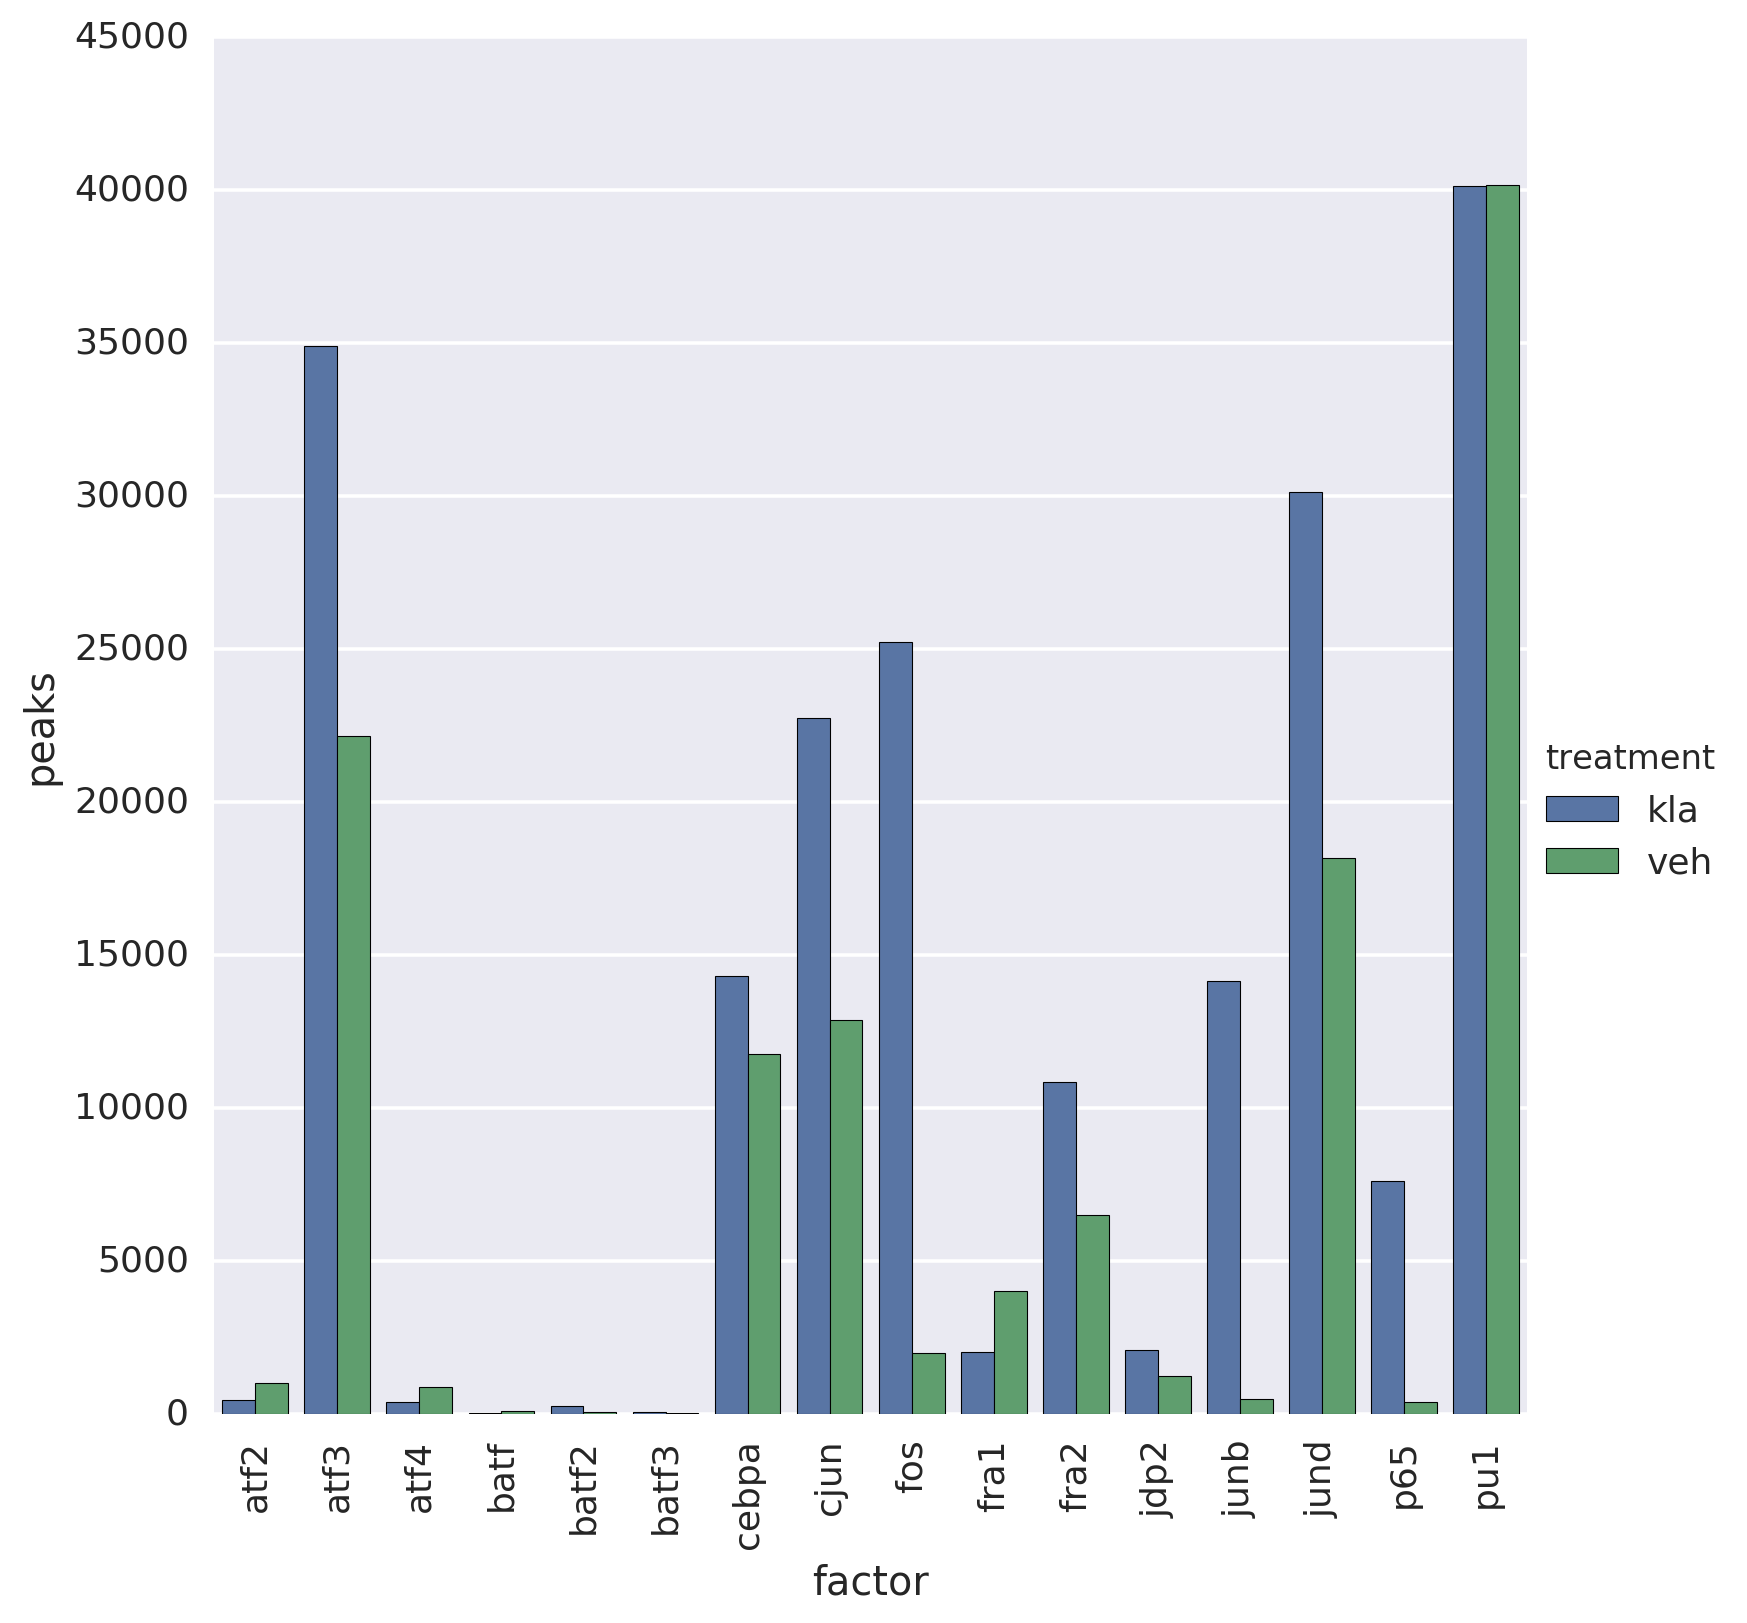

In [77]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/ap1_idr/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar')
plt.xticks(rotation=90)
# plt.ylim([0,30000])
    

In [78]:
outFile = open('./best_samples.tsv','w')
! if [ ! -d idrPeaks ]; then mkdir idrPeaks; fi
!rm ./idrPeaks/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()



rm: cannot remove ‘./idrPeaks/*’: No such file or directory
c57bl6	atf2	kla	C57Bl6_Thiomac_ChIP_ATF2_KLA-1h_GJF_14-08-07	C57Bl6_Thiomac_ChIP_ATF2_KLA-1h_GJF_15-02-06	458
c57bl6	atf2	veh	C57Bl6_Thiomac_ChIP_ATF2_Veh_GJF_14-08-07	C57Bl6_Thiomac_ChIP_ATF2_Veh_GJF_16-06-14	1010
c57bl6	atf3	kla	C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21	C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16	34885
c57bl6	atf3	veh	C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21	C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23	22161
c57bl6	atf4	kla	C57Bl6_Thiomac_ChIP_ATF4_KLA-1h_GFEW_15-08-18	C57Bl6_Thiomac_ChIP_ATF4_KLA-1h_GJF_16-06-14	411
c57bl6	atf4	veh	C57Bl6_Thiomac_ChIP_ATF4_Veh_GJF_15-06-29	C57Bl6_Thiomac_ChIP_ATF4_Veh_GJF_16-06-14	888
c57bl6	batf2	kla	C57Bl6_Thiomac_ChIP_Batf2_KLA-1h_GJF_14-08-07	C57Bl6_Thiomac_ChIP_Batf2_KLA-1h_GJF_16-06-14	265
c57bl6	batf2	veh	C57Bl6_Thiomac_ChIP_Batf2_Veh_GJF_14-08-07	C57Bl6_Thiomac_ChIP_Batf2_Veh_GJF_15-02-06	75
c57bl6	batf3	kla	C57Bl6_Thiomac_ChIP_Batf3_KLA-1h_GJF_14-08-07	C57Bl6_Thi

In [80]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(factorTreatment_bestIDR_dict.keys()):
for key in [
 'c57bl6_atf3_kla',
 'c57bl6_atf3_veh',
 'c57bl6_cebpa_kla',
 'c57bl6_cebpa_veh',
 'c57bl6_cjun_kla',
 'c57bl6_cjun_veh',
 'c57bl6_fos_kla',
 'c57bl6_fos_veh',
 'c57bl6_fra2_veh',
 'c57bl6_fra2_kla',
 'c57bl6_junb_kla',
 'c57bl6_junb_veh',
 'c57bl6_jund_kla',
 'c57bl6_jund_veh',
 'c57bl6_p65_kla',
 'c57bl6_p65_veh',
 'c57bl6_pu1_kla',
 'c57bl6_pu1_veh']:
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString
! makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString

makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d ./tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21 ./tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16 ./tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21 ./tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23 ./tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_GFEW_15-11-18 ./tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_SH_11-05-12 ./tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_Veh_GFEW_15-11-18 ./tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_Veh_SH_11-05-12 ./tag_directories/C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GFEW_15-11-18 ./tag_directories/C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GJF_16-04-21 ./tag_directories/C57Bl6_Thiomac_ChIP_cJun_Veh_GFEW_15-11-18 ./tag_directories/C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_16-04-21 ./tag_directories/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_14-03-17 ./tag_directories/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_15-02-06 ./tag_directories/C57Bl6_Thiomac_ChIP_Fos

### Create Scatter Plot Visualization

In [81]:
!ls idrPeaks/

c57bl6_atf2_kla_peaks.tsv   c57bl6_fos_kla_peaks.tsv
c57bl6_atf2_veh_peaks.tsv   c57bl6_fos_veh_peaks.tsv
c57bl6_atf3_kla_peaks.tsv   c57bl6_fra1_kla_peaks.tsv
c57bl6_atf3_veh_peaks.tsv   c57bl6_fra1_veh_peaks.tsv
c57bl6_atf4_kla_peaks.tsv   c57bl6_fra2_kla_peaks.tsv
c57bl6_atf4_veh_peaks.tsv   c57bl6_fra2_veh_peaks.tsv
c57bl6_batf2_kla_peaks.tsv  c57bl6_jdp2_kla_peaks.tsv
c57bl6_batf2_veh_peaks.tsv  c57bl6_jdp2_veh_peaks.tsv
c57bl6_batf3_kla_peaks.tsv  c57bl6_junb_kla_peaks.tsv
c57bl6_batf3_veh_peaks.tsv  c57bl6_junb_veh_peaks.tsv
c57bl6_batf_kla_peaks.tsv   c57bl6_jund_kla_peaks.tsv
c57bl6_batf_veh_peaks.tsv   c57bl6_jund_veh_peaks.tsv
c57bl6_cebpa_kla_peaks.tsv  c57bl6_p65_kla_peaks.tsv
c57bl6_cebpa_veh_peaks.tsv  c57bl6_p65_veh_peaks.tsv
c57bl6_cjun_kla_peaks.tsv   c57bl6_pu1_kla_peaks.tsv
c57bl6_cjun_veh_peaks.tsv   c57bl6_pu1_veh_peaks.tsv


## Strains Peak Calling

In [37]:
# file directories

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(workingDirectory + '/tag_directories_strains')):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(workingDirectory + '/tag_directories_strains')):
    logFile = [x for x in os.listdir(workingDirectory + '/tag_directories_strains' + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(workingDirectory + '/tag_directories_strains' + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(workingDirectory + '/tag_directories_strains'):
    with open(workingDirectory + '/tag_directories_strains/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [39]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

Number of Samples: 75
Number of discarded samples: 3
Number of Samples remaining after filtering: 72


In [43]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
### call peaks ###
# iterate through each individual file
! if [ ! -d ./peak_files_strains/ ]; then mkdir ./peak_files_strains; else rm ./peak_files_strains/*; fi

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr_strains.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer_strains.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    if not 'input' in tagDir.lower():
    # call peaks only for experiments that passed thresholding
        metaDataTokens = tagDir.split("_")
        treatment = metaDataTokens[4]
        strain = metaDataTokens[0]

        peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
        peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

        if strain == 'Balbc':
            if "veh" in treatment.lower():
                inputDir = './input_data/Balbc_Thiomac_ChIP_Input_Veh_GJF_16-06-12'
            elif "kla" in treatment.lower():
                inputDir = './input_data/Balbc_Thiomac_ChIP_Input_KLA-1h_GJF_16-06-12'        
        elif strain == 'NOD':
            if "veh" in treatment.lower():
                inputDir = './input_data/NOD_Thiomac_ChIP_Input_Veh_GFEW_15-10-19'
            elif "kla" in treatment.lower():
                inputDir = './input_data/NOD_Thiomac_ChIP_Input_KLA-1h_GFEW_15-10-19'
        scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                         ' -i ' + inputDir
                         + ' -L 0 -C 0 -fdr 0.9' 
                         + ' -style factor -size 200  > ' + 
                         './peak_files_strains/' + peakFileName1 + ' &\n')
        scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -style factor -size 200  > ' + 
                     './peak_files_strains/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()




In [44]:
%%bash
rm ./peak_files_strains/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr_strains.sh

rm: cannot remove ‘./peak_files_strains/*’: No such file or directory
	Fragment Length = 135
	Fragment Length = 111
	Total Tags = 18314997.0
	Tags per bp = 0.009157
	Max tags per bp set automatically to 1.0
	Total Tags = 12944473.0
	Tags per bp = 0.006472
	Max tags per bp set automatically to 1.0
	Fragment Length = 128
	Total Tags = 12164933.0
	Tags per bp = 0.006082
	Max tags per bp set automatically to 1.0
	Fragment Length = 131
	Total Tags = 12068143.0
	Tags per bp = 0.006034
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 132
	Finding peaks of size 200, no closer than 400
	Total Tags = 10784936.0
	Tags per bp = 0.005392
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 143
	Total Tags = 12580271.0
	Tags per bp = 0.006290
	Max tags per bp set automatically to 1.0
	Fragment Length = 125
	Total Tags = 23530134.0
	Tags per bp = 0.011765
	Max tags per bp set automaticall

### Run IDR for strains

In [48]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_strains/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./idr_strains/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = './peak_files_strains/' + sample1 + '_peaks.tsv'
            peakFile2 = './peak_files_strains/' + sample2 + '_peaks.tsv'
            
            ! echo "python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            ! python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory

python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_strains/balbc_fos_kla_10-19-15_1_peaks.tsv ./peak_files_strains/balbc_fos_kla_16-07-22_1_peaks.tsv /home/jtao/analysis/ap1_analysis/idr_strains/ &
python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_strains/balbc_fos_kla_10-19-15_1_peaks.tsv ./peak_files_strains/balbc_fos_kla_16-08-16_1_peaks.tsv /home/jtao/analysis/ap1_analysis/idr_strains/ &
python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_strains/balbc_fos_kla_16-07-22_1_peaks.tsv ./peak_files_strains/balbc_fos_kla_16-08-16_1_peaks.tsv /home/jtao/analysis/ap1_analysis/idr_strains/ &
python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_strains/nod_fos_veh_10-19-15_1_peaks.tsv ./peak_files_strains/nod_fos_veh_16-07-22_1_peaks.tsv /home/jtao/analysis/ap1_analysis/idr_strains/ &
python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_strains/nod_fos_veh_10-19-15_1_peaks.tsv ./peak_fil

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(....) is deprecated, use sort_index(.....)


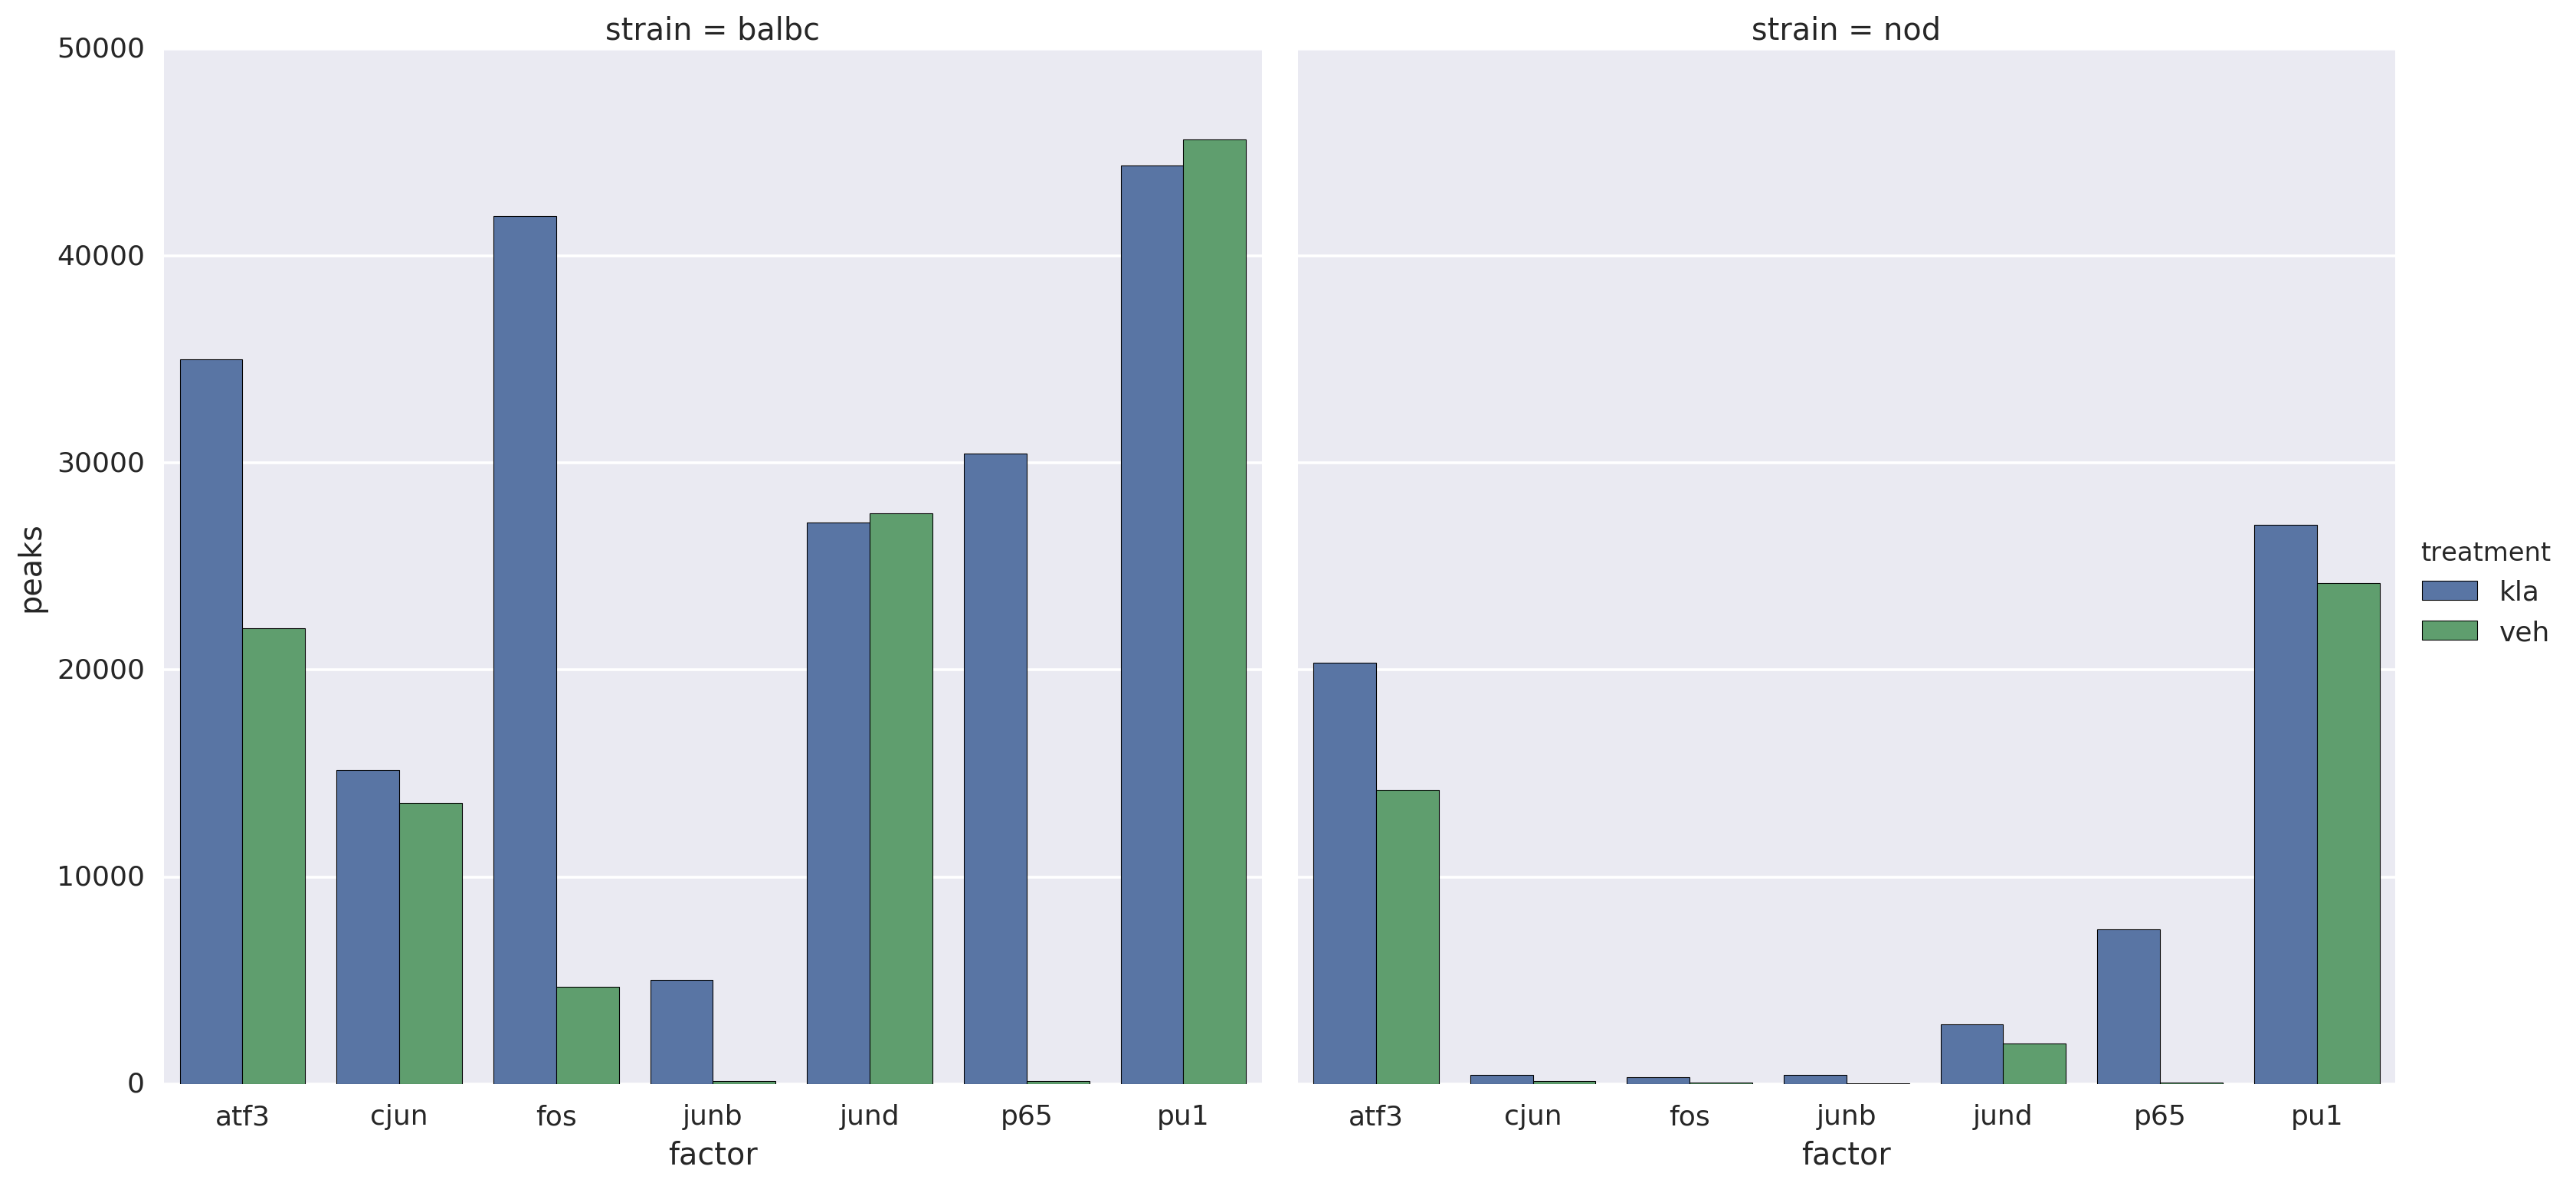

In [50]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_strains//'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar', col='strain')
# plt.ylim([0,30000])
    

In [51]:
outFile = open('./best_samples_strains.tsv','w')
! if [ ! -d idrPeaks_strains ]; then mkdir idrPeaks_strains; fi
!rm ./idrPeaks_strains/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks_strains/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()

balbc	atf3	kla	Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-07-25	Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16-rep1	35027
balbc	atf3	veh	Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16	Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16-rep1	22018
balbc	cjun	kla	Balbc_Thiomac_ChIP_cJun_KLA-1h_GFEW_10-19-15	Balbc_Thiomac_ChIP_cJun_KLA-1h_GJF_16-06-12	15187
balbc	cjun	veh	Balbc_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15	Balbc_Thiomac_ChIP_cJun_Veh_GJF_16-06-12	13564
balbc	fos	kla	Balbc_Thiomac_ChIP_Fos_KLA-1h_GFEW_10-19-15	Balbc_Thiomac_ChIP_Fos_KLA-1h_GJF_16-07-22	41941
balbc	fos	veh	Balbc_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15	Balbc_Thiomac_ChIP_Fos_Veh_GJF_16-07-22	4701
balbc	junb	kla	Balbc_Thiomac_ChIP_JunB_KLA-1h_GFEW_10-19-15	Balbc_Thiomac_ChIP_JunB_KLA-1h_GJF_16-07-22	5014
balbc	junb	veh	Balbc_Thiomac_ChIP_JunB_Veh_GFEW_10-19-15	Balbc_Thiomac_ChIP_JunB_Veh_GJF_16-07-22	153
balbc	jund	kla	Balbc_Thiomac_ChIP_JunD_KLA-1h_GFEW_10-19-15	Balbc_Thiomac_ChIP_JunD_KLA-1h_GJF_16-06-12	27138
balbc	jund	veh	Balbc_Thiomac_ChIP_Ju

In [52]:
# create track hub containing best samples
tagDirectories = []
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_strains/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString
! makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString

makeMultiWigHub.pl ap1_idr_strains mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-07-25 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16-rep1 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16 ./tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16-rep1 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GJF_16-06-12 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GJF_16-06-12 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GJF_16-07-22 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15 ./tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GJF_16-07-22 ./tag_directories_strains/Balbc_Thiomac_ChIP_JunB_KLA-1h_GFEW_10-19-1

## Validation Peak Calling

In [61]:
# file directories

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(workingDirectory + '/tag_directories_validation')):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in sorted(os.listdir(workingDirectory + '/tag_directories_validation')):
    logFile = [x for x in os.listdir(workingDirectory + '/tag_directories_validation' + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(workingDirectory + '/tag_directories_validation' + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(workingDirectory + '/tag_directories_validation'):
    with open(workingDirectory + '/tag_directories_validation/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [62]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 100000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

Number of Samples: 38
Number of discarded samples: 0
Number of Samples remaining after filtering: 38


In [63]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_validation/'
### call peaks ###
# iterate through each individual file
! if [ ! -d ./peak_files_validation/ ]; then mkdir ./peak_files_validation; else rm ./peak_files_validation/*; fi

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open(scratchDirectory + '/peakCalling_homer_idr_validation.sh', 'w')
scriptFile2 = open(scratchDirectory + '/peakCalling_homer_validation.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    if not 'input' in tagDir.lower():
    # call peaks only for experiments that passed thresholding
        metaDataTokens = tagDir.split("_")
        treatment = metaDataTokens[4]

        peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
        peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

        if "veh" in treatment.lower():
            inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
        elif "kla" in treatment.lower():
            inputDir = './input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
            
        scriptFile1.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                         ' -i ' + inputDir
                         + ' -L 0 -C 0 -fdr 0.9' 
                         + ' -style factor -size 200  > ' + 
                         './peak_files_validation/' + peakFileName1 + ' &\n')
        scriptFile2.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir
                     + ' -style factor -size 200  > ' + 
                     './peak_files_validation/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()




In [64]:
%%bash
rm ./peak_files_validation/*
chmod a+x ./scratch/*
bash ./scratch/peakCalling_homer_idr_validation.sh

rm: cannot remove ‘./peak_files_validation/*’: No such file or directory
	Fragment Length = 130
	Total Tags = 7088288.0
	Tags per bp = 0.003544
	Max tags per bp set automatically to 1.0
	Fragment Length = 116
	Finding peaks of size 200, no closer than 400
	Total Tags = 20801434.0
	Tags per bp = 0.010401
	Max tags per bp set automatically to 1.0
	Fragment Length = 143
	Total Tags = 14541228.0
	Tags per bp = 0.007271
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 113
	Finding peaks of size 200, no closer than 400
	Total Tags = 21458548.0
	Tags per bp = 0.010729
	Max tags per bp set automatically to 1.0
	Fragment Length = 124
	Total Tags = 25189711.0
	Tags per bp = 0.012595
	Max tags per bp set automatically to 1.0
	Fragment Length = 135
	Total Tags = 28386856.0
	Tags per bp = 0.014193
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 100
	Fragment Length = 108
	Total Tag

## Run IDR for Validation ChIPs

In [65]:
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_validation/'

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./idr_validation/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'simplifiedName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = './peak_files_validation/' + sample1 + '_peaks.tsv'
            peakFile2 = './peak_files_validation/' + sample2 + '_peaks.tsv'
            
            ! echo "python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory &"
            ! python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py $peakFile1 $peakFile2 $idrDirectory



python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py ./peak_files_validation/c57bl6-ppargko_cjun_veh_16-07-23-1_1_peaks.tsv ./peak_files_validation/c57bl6-ppargko_cjun_veh_16-07-23-2_1_peaks.tsv /home/jtao/analysis/ap1_analysis/idr_validation/ &
Performing IDR analysis on the following samples: ./peak_files_validation/c57bl6-ppargko_cjun_veh_16-07-23-1_1_peaks.tsv, ./peak_files_validation/c57bl6-ppargko_cjun_veh_16-07-23-2_1_peaks.tsv
Output files will be written to: /home/jtao/analysis/ap1_analysis/idr_validation/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score'
 'Total Tags (normalized to Control Experiment)' 'Control Tags'
 'Fold Change vs Control' 'p-value vs Control' 'Score']
/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(....) is deprecated, use sort_index(.....)


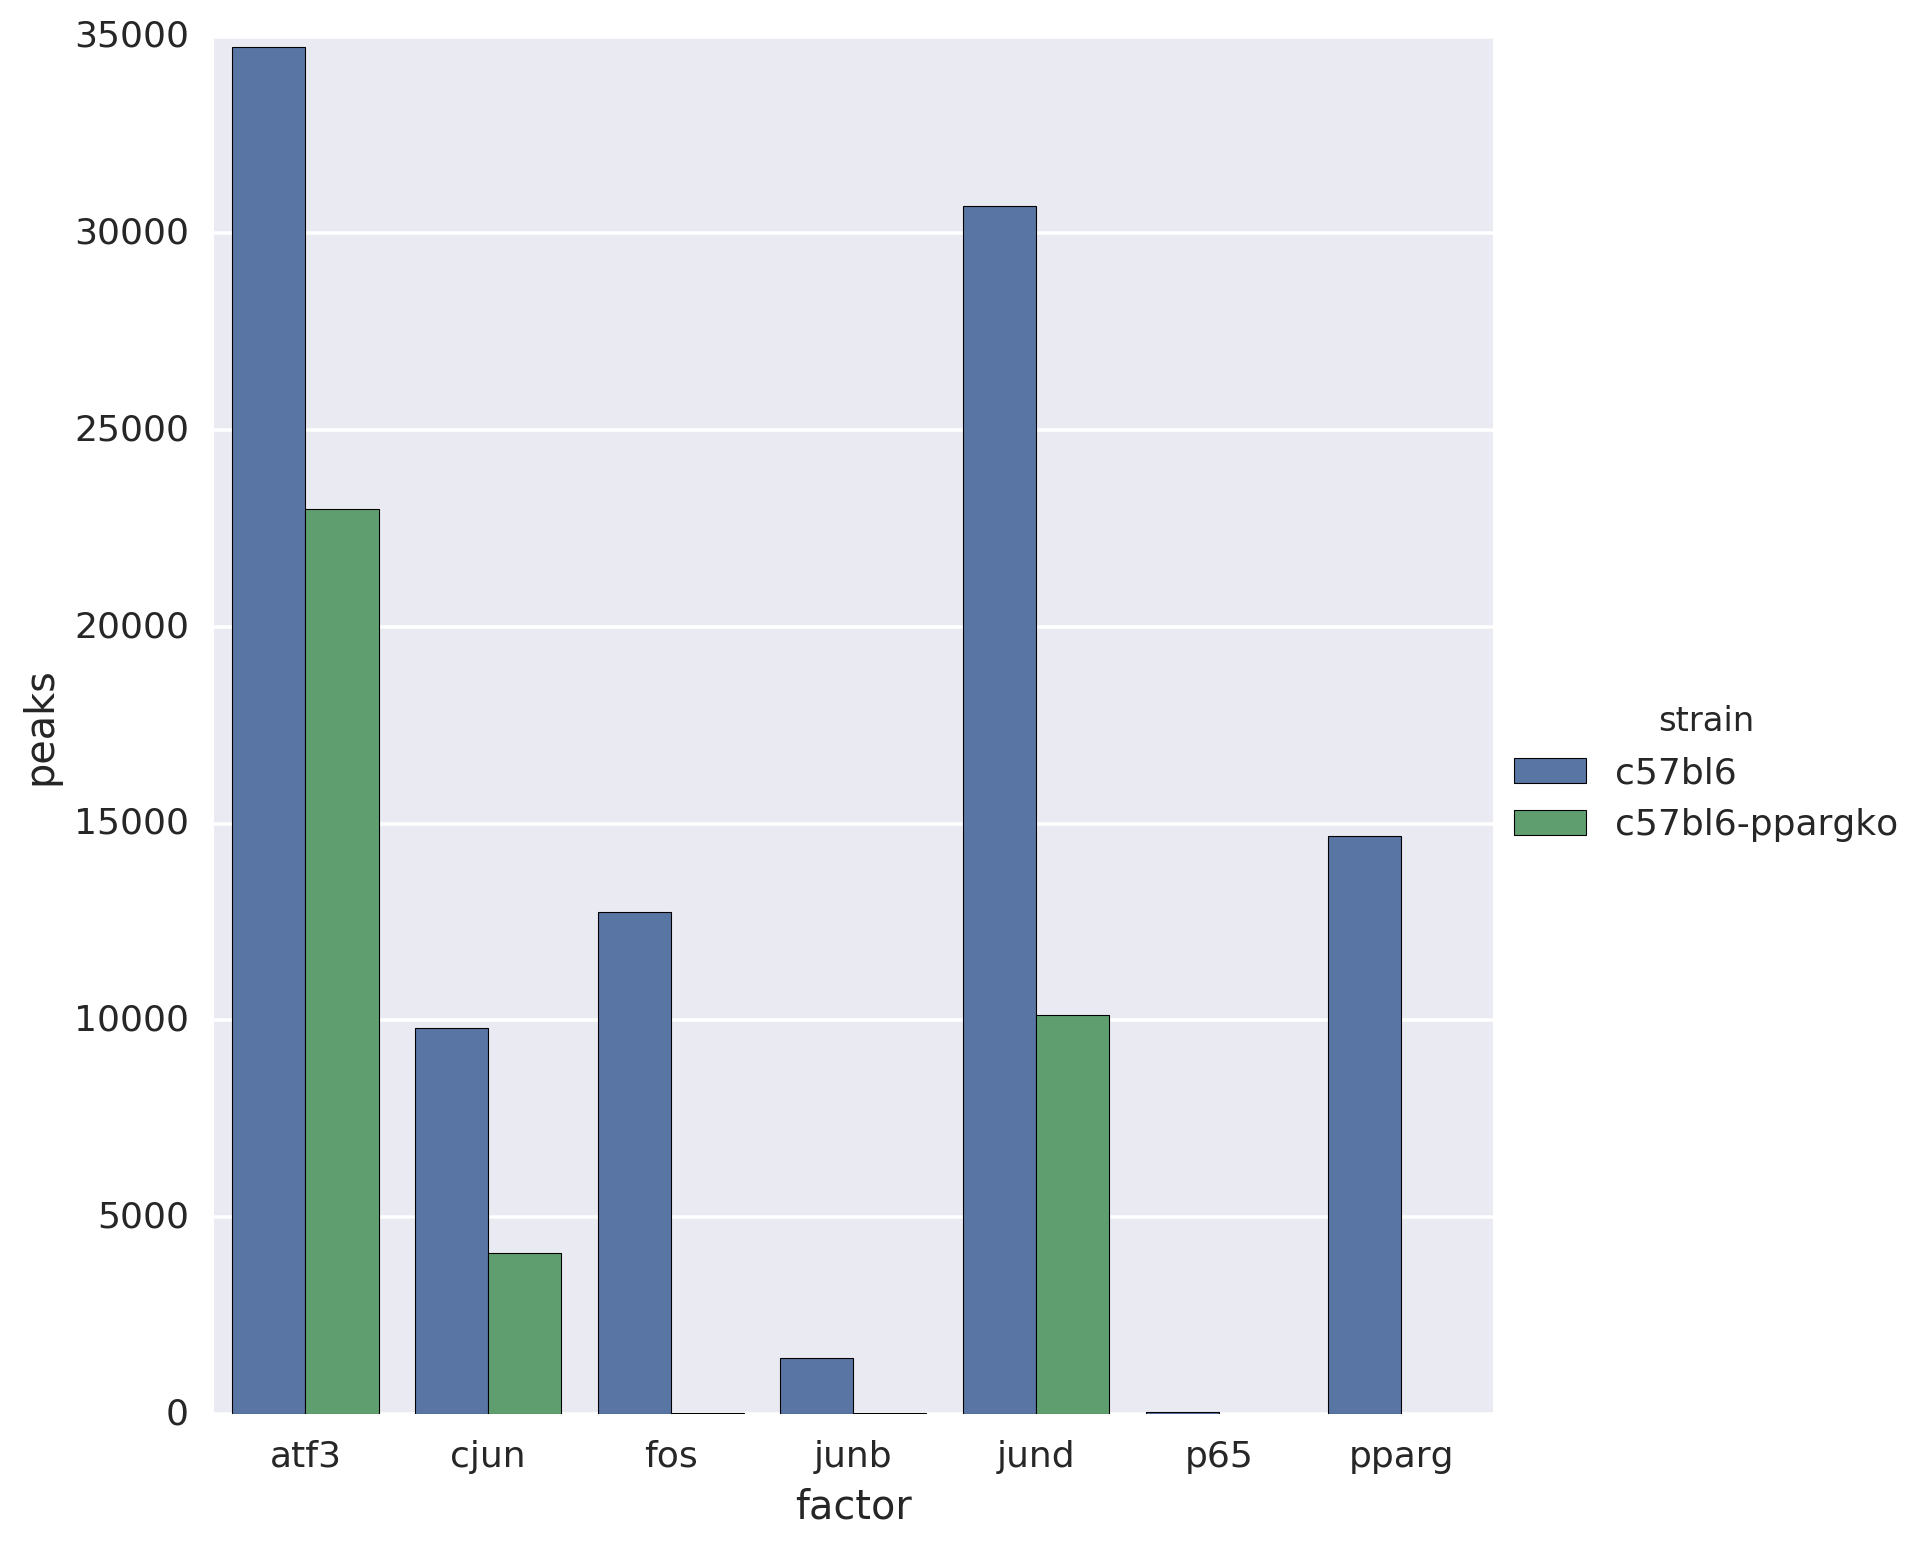

In [66]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ap1_analysis/idr_validation/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:3])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[1])
    treatments.append(tokens[2])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='strain', size =8, kind='bar')
# plt.ylim([0,30000])
    

In [67]:
outFile = open('./best_samples_validation.tsv','w')
! if [ ! -d idrPeaks_validation ]; then mkdir idrPeaks_validation; fi
!rm ./idrPeaks_strains/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks_validation/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()

c57bl6-ppargko	atf3	veh	C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-2	22993
c57bl6-ppargko	cjun	veh	C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-2	4080
c57bl6-ppargko	fos	veh	C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-2	9
c57bl6-ppargko	junb	veh	C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-2	24
c57bl6-ppargko	jund	veh	C57Bl6-PPARgKO_Thiomac_ChIP_JunD_Veh_GJF_16-07-23-1	C57Bl6-PPARgKO_Thiomac_ChIP_JunD_Veh_GJF_16-07-23-2	10143
c57bl6	atf3	ikkvii	C57Bl6_Thiomac_ChIP_ATF3_IKKVii-1h-KLA-1h_GJF_16-07-18	C57Bl6_Thiomac_ChIP_ATF3_IKKVii-1h-KLA-1h_GJF_16-07-22	34744
c57bl6	cjun	ikkvii	C57Bl6_Thiomac_ChIP_cJun_IKKVii-1h-KLA-1h_GJF_16-07-22	C57Bl6_Thiomac_ChIP_cJun_IKKVii-1h-KLA-1h_GJF_16-08-16-rep2	9815
c57bl6	fos	ikkvii	C57Bl6_Thiomac_ChIP_Fos_IKKVii-1h-KLA-1h_GJF_16-0

In [69]:
# create track hub containing best samples
tagDirectories = []
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:5])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[6:11])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_validation/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString
! makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d $tagDirString




makeMultiWigHub.pl ap1_idr_validation mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 5e6 -d ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_cJun_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_Fos_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_JunB_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_JunD_Veh_GJF_16-07-23-1 ./tag_directories_validation/C57Bl6-PPARgKO_Thiomac_ChIP_JunD_Veh_GJF_16-07-23-2 ./tag_directories_validation/C57Bl6_Thiomac_ChIP_ATF3_IKKVii-1h-KLA-1h_GJF_16-07-18 ./tag_

## Enhancer Marks Stuff

In [228]:
# annotate peaks with enhancer marks
!annotatePeaks.pl /home/jtao/analysis/ap1_analysis/merged_peaks.tsv mm10 -size 1000 -d tag_directories_enhancerMarks/* > merged_annotated_peaks.tsv


	Peak file = /home/jenhan/analysis/ap1_analysis/merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Tag Directories:
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_KLA-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-08-13
		tag_directories_enhancerMarks/C57Bl6_ThioMac_GRO_notx-1h_NJS_10-09-01
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_KLA-1h_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K27Ac_notx_CR_12-07-06
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_KLA-1h_Josh_14-04-22
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_13-02-07
		tag_directories_enhancerMarks/C57Bl6_ThioMac_H3K4me1_notx-1h_Josh_14-04-22
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 21906
		Duplicated Peak I

In [14]:
# read in peak data data
summary_frame = pd.read_csv('/home/jtao/analysis/ap1_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[4:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
    
summary_frame['chr'] = [x.split(':')[0] for x in summary_frame['Position'].values]
summary_frame['numFactors'] = [len(x.split(',')) for x in summary_frame['Factors'].values]


summary_frame.index = summary_frame['ID'].values
newCols = list(summary_frame.columns.values)[:4] + ['chr', 'numFactors'] + list(summary_frame.columns.values)[4:-2]

summary_frame = summary_frame[newCols]



del summary_frame['Group Number']
del summary_frame['numFactors']

_factors = sorted(set(list(set([x.split('_')[0] for x in summary_frame.columns if '_' in x]))))

columns = summary_frame.columns
for f in _factors:
    if not f + '_veh' in columns:
        summary_frame[f + '_veh'] = [0.0] * summary_frame.shape[0]
    if not f + '_kla' in columns:
        summary_frame[f + '_kla'] = [0.0] * summary_frame.shape[0]

In [ ]:
# read in enhancer marks
enhancer_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
enhancer_frame.index=enhancer_frame.ix[:,0].values
for i in [
'Chr',
 'Start',
 'End',
 'Strand',
 'Peak Score',
 'Focus Ratio/Region Size',
 'Detailed Annotation',
 'Distance to TSS',
 'Nearest PromoterID',
 'Entrez ID',
 'Nearest Unigene',
 'Nearest Refseq',
 'Nearest Ensembl',
 'Gene Name',
 'Gene Alias',
 'Gene Description',
 'Gene Type']:
    del enhancer_frame[i]
columns = enhancer_frame.columns.values

columns[0] = 'ID'

# drop bad H3K4me1 samples
columns = [x for x in columns if not 'Josh_13-02-07' in x]
enhancer_frame = enhancer_frame[columns]

columns = ['_'.join(x.split('/')[1].split()[0].replace('-1h','').split('_')[2:4]) if '/' in x else x for x in columns]

# change notx and KLA to veh and kla
columns = [x.lower().replace('notx', 'veh') if '_' in x else x for x in columns]
enhancer_frame.columns = columns

# clean up annotations
enhancer_frame['Annotation'] = [x.split('(')[0].strip() for x in enhancer_frame['Annotation'].values]



# summary_frame = summary_frame.merge(data_frame, on='ID')

_enhancerMarks = sorted(list(set(enhancer_frame.columns.values[2:])))

# make scatter plots for all marks that have a replicate
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        toPlot=enhancer_frame[em]
        plt.scatter(np.log2(toPlot.ix[:,0]), np.log2(toPlot.ix[:,1]))
        plt.title(em)
        plt.show()

# average the values of replicates
for em in _enhancerMarks:
    if len(enhancer_frame[em].shape) > 1:
        vals = np.mean(enhancer_frame[em], axis=1)
        del enhancer_frame[em]
        enhancer_frame[em] = vals
        
# remove outlier GRO-seq values
enhancer_frame.loc[enhancer_frame['gro_veh'] > 10000, 'gro_veh' ] = 0
enhancer_frame.loc[enhancer_frame['gro_kla'] > 10000, 'gro_kla' ] = 0

In [22]:
sns.set_context('talk', font_scale=0.6)
id_annotation_dict = dict(zip(enhancer_frame['ID'].values, enhancer_frame['Annotation'].values))
annotationTypes = set(enhancer_frame['Annotation'].values)
pie_color_dict = dict(zip(annotationTypes, sns.color_palette('colorblind', len(annotationTypes))))
hf, ha = plt.subplots(1,3)

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    
    # for veh
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in veh_ids]
    plt.subplot(1,3,1)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' veh (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[0].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    # for shared peaks
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in shared_ids]
    plt.subplot(1,3,2)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' shared (' + str(len(annotations)) +' peaks)')
        plt.axis('equal')
    else:
        ha[1].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    
    # for KLA
    labels = []
    counts =  []
    colors = []
    annotations = [id_annotation_dict[x] for x in kla_ids]
    plt.subplot(1,3,3)
    if annotations:
        for ann in annotationTypes:
            c = annotations.count(ann)
            counts.append(c)
            if c/float(len(annotations)) > 0.05:
                labels.append(ann)
            else:
                labels.append('')
            colors.append(pie_color_dict[ann])
        plt.pie(counts, labels = labels, colors=colors);
        plt.title(f + ' kla (' + str(len(annotations)) +' peaks)')        
        plt.axis('equal')
    else:
        ha[2].axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_axis_bgcolor('white')
    plt.savefig(f + '_annotationPie.png')
    plt.close()
sns.set_context('talk', font_scale=1.0)    

In [23]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in _factors:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.savefig(f+ "_enhancerMarks.png")
    plt.close()
sns.set_context('talk', font_scale=1.0)



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1712: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


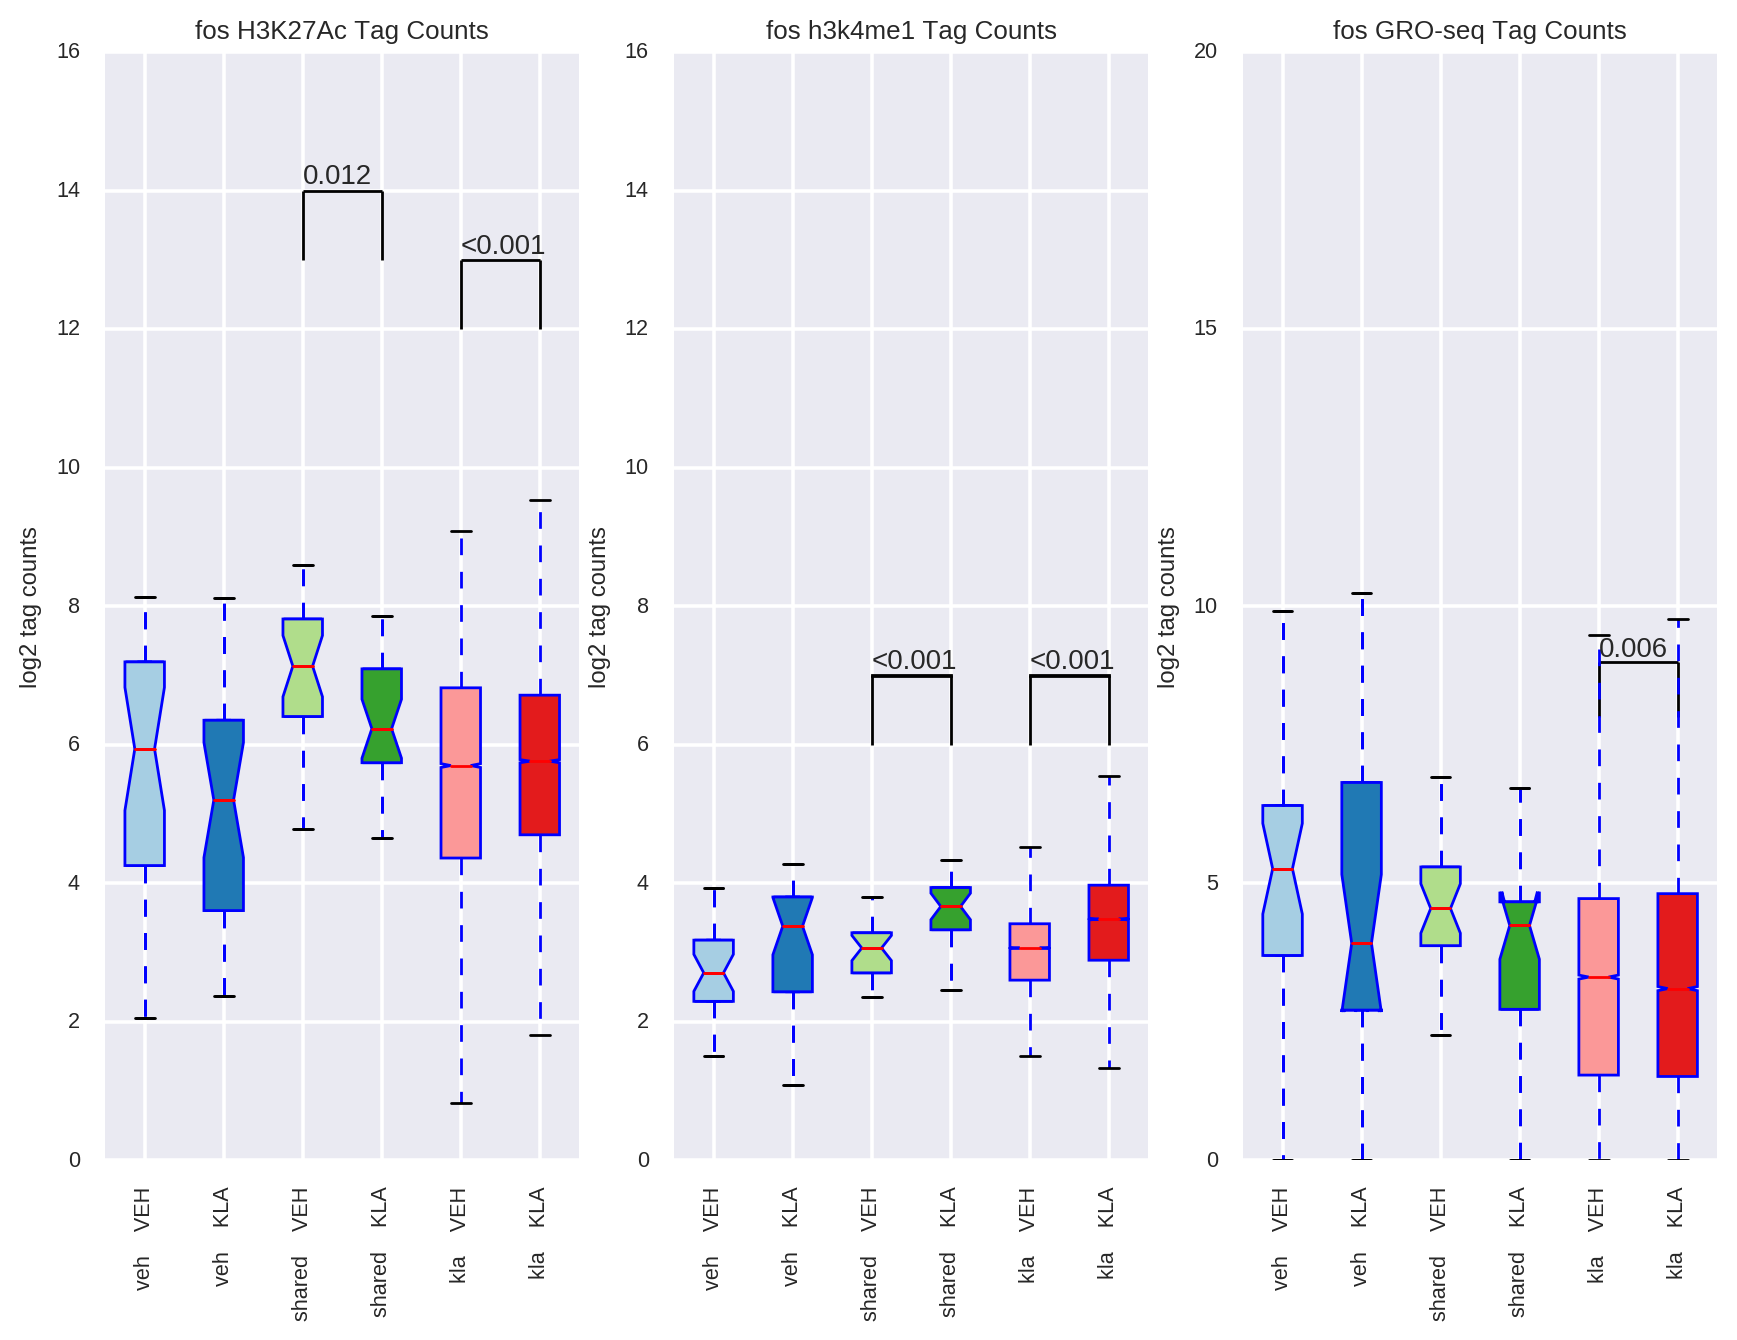

In [24]:
# plot enhancer mark boxplots
# colors = []
# for i in sns.color_palette('colorblind',8):
#     colors.append(i)
#     colors.append(i)
sns.set_context('talk', font_scale=0.6)
colors = sns.color_palette('Paired',8)
p_threshold = 0.05

for f in ['fos']:
    veh_f = f + '_veh'
    kla_f = f+ '_kla'
    veh_ids = enhancer_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] == 0)]['ID'].values
    kla_ids = summary_frame[(summary_frame[veh_f] == 0) & (summary_frame[kla_f] > 0)]['ID'].values
    shared_ids = summary_frame[(summary_frame[veh_f] > 0) & (summary_frame[kla_f] > 0)]['ID'].values
    id_lists = [veh_ids, shared_ids, kla_ids]
    id_names = ['veh', 'shared', 'kla']

    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,1)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        ### h3k27ac
        veh_values = enhancer_frame.ix[ids,'h3k27ac_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k27ac_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' H3K27Ac Tag Counts')
    ### for h3k4me1
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,2)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'h3k4me1_veh'].values
        kla_values = enhancer_frame.ix[ids,'h3k4me1_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,16])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' h3k4me1 Tag Counts')
    
    # for Gro seq
    counts = []
    labels = []
    pvals = []
    plt.subplot(1,3,3)
    for i in range(len(id_lists)):
        ids = id_lists[i]
        veh_values = enhancer_frame.ix[ids,'gro_veh'].values
        kla_values = enhancer_frame.ix[ids,'gro_kla'].values
        veh_values = np.log2(veh_values + 1)
        kla_values = np.log2(kla_values + 1)
        
        if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
            labels.append(id_names[i] +'    VEH')
            labels.append(id_names[i] +'    KLA')
            counts.append(veh_values)
            counts.append(kla_values)
            stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
            pvals.append(p)
            
            box = plt.boxplot(counts, notch=True, patch_artist=True);

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    # annotate plot with p_values
    ax = plt.gca()
    for i in range(len(pvals)):
        p = pvals[i]
        if p < p_threshold: 
            height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
            ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
            ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
            ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

    plt.xticks(range(1,len(labels)+1), labels, rotation =90);
    plt.ylim([0,20])
    plt.ylabel('log2 tag counts')
    plt.title(f + ' GRO-seq Tag Counts')
    plt.show()
    plt.close()
sns.set_context('talk', font_scale=1.0)




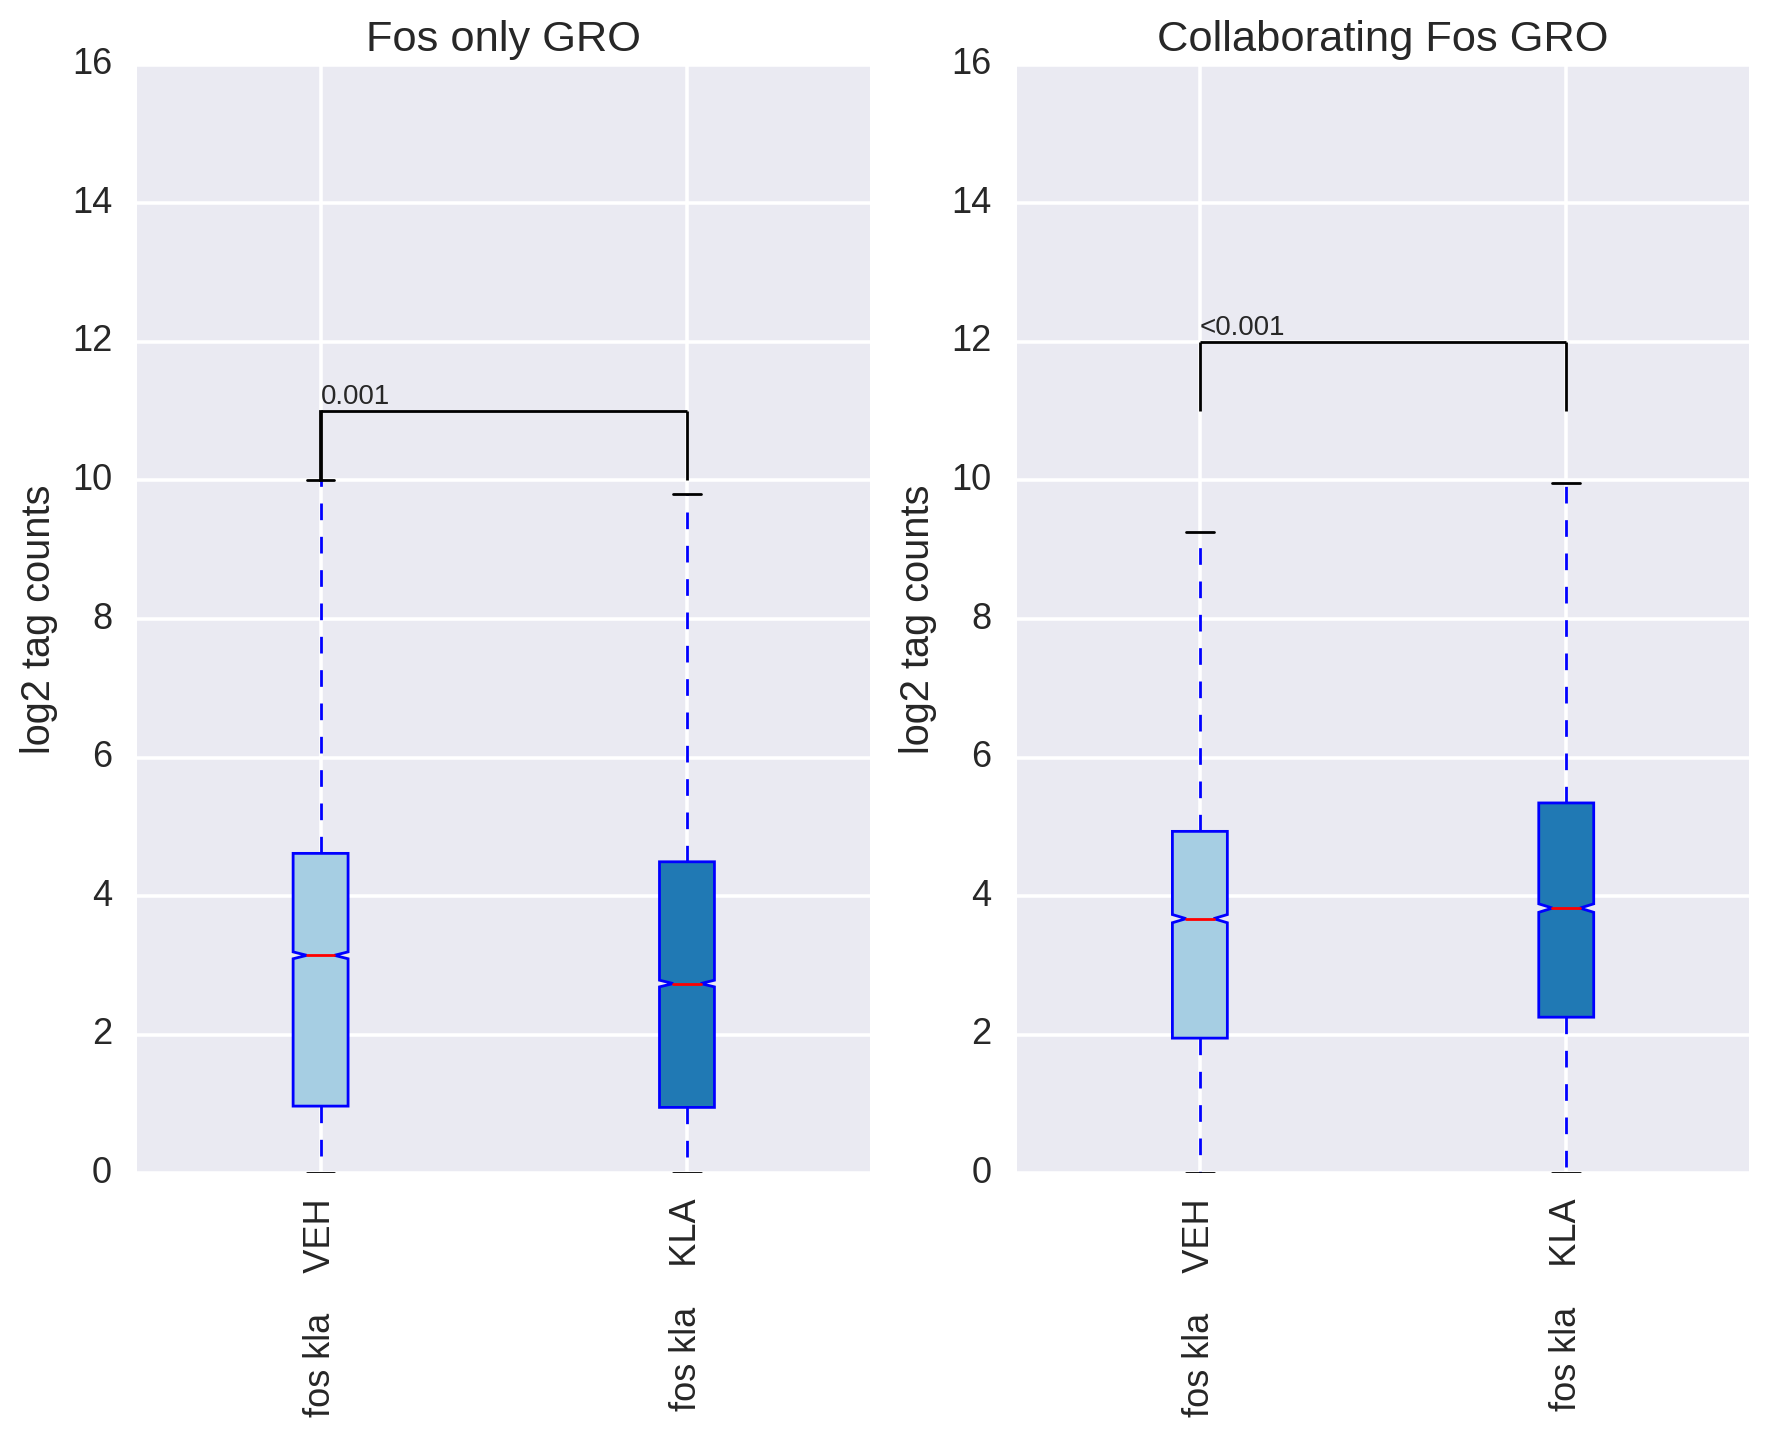

In [25]:
fos_only_ids = summary_frame[summary_frame.sum(axis=1)==summary_frame['fos_kla']]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,2,1)
veh_values = enhancer_frame.ix[fos_only_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_only_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Fos only GRO')

fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values
counts = []
labels = []
pvals = []
plt.subplot(1,2,2)
ids = fos_only_ids
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('Collaborating Fos GRO')


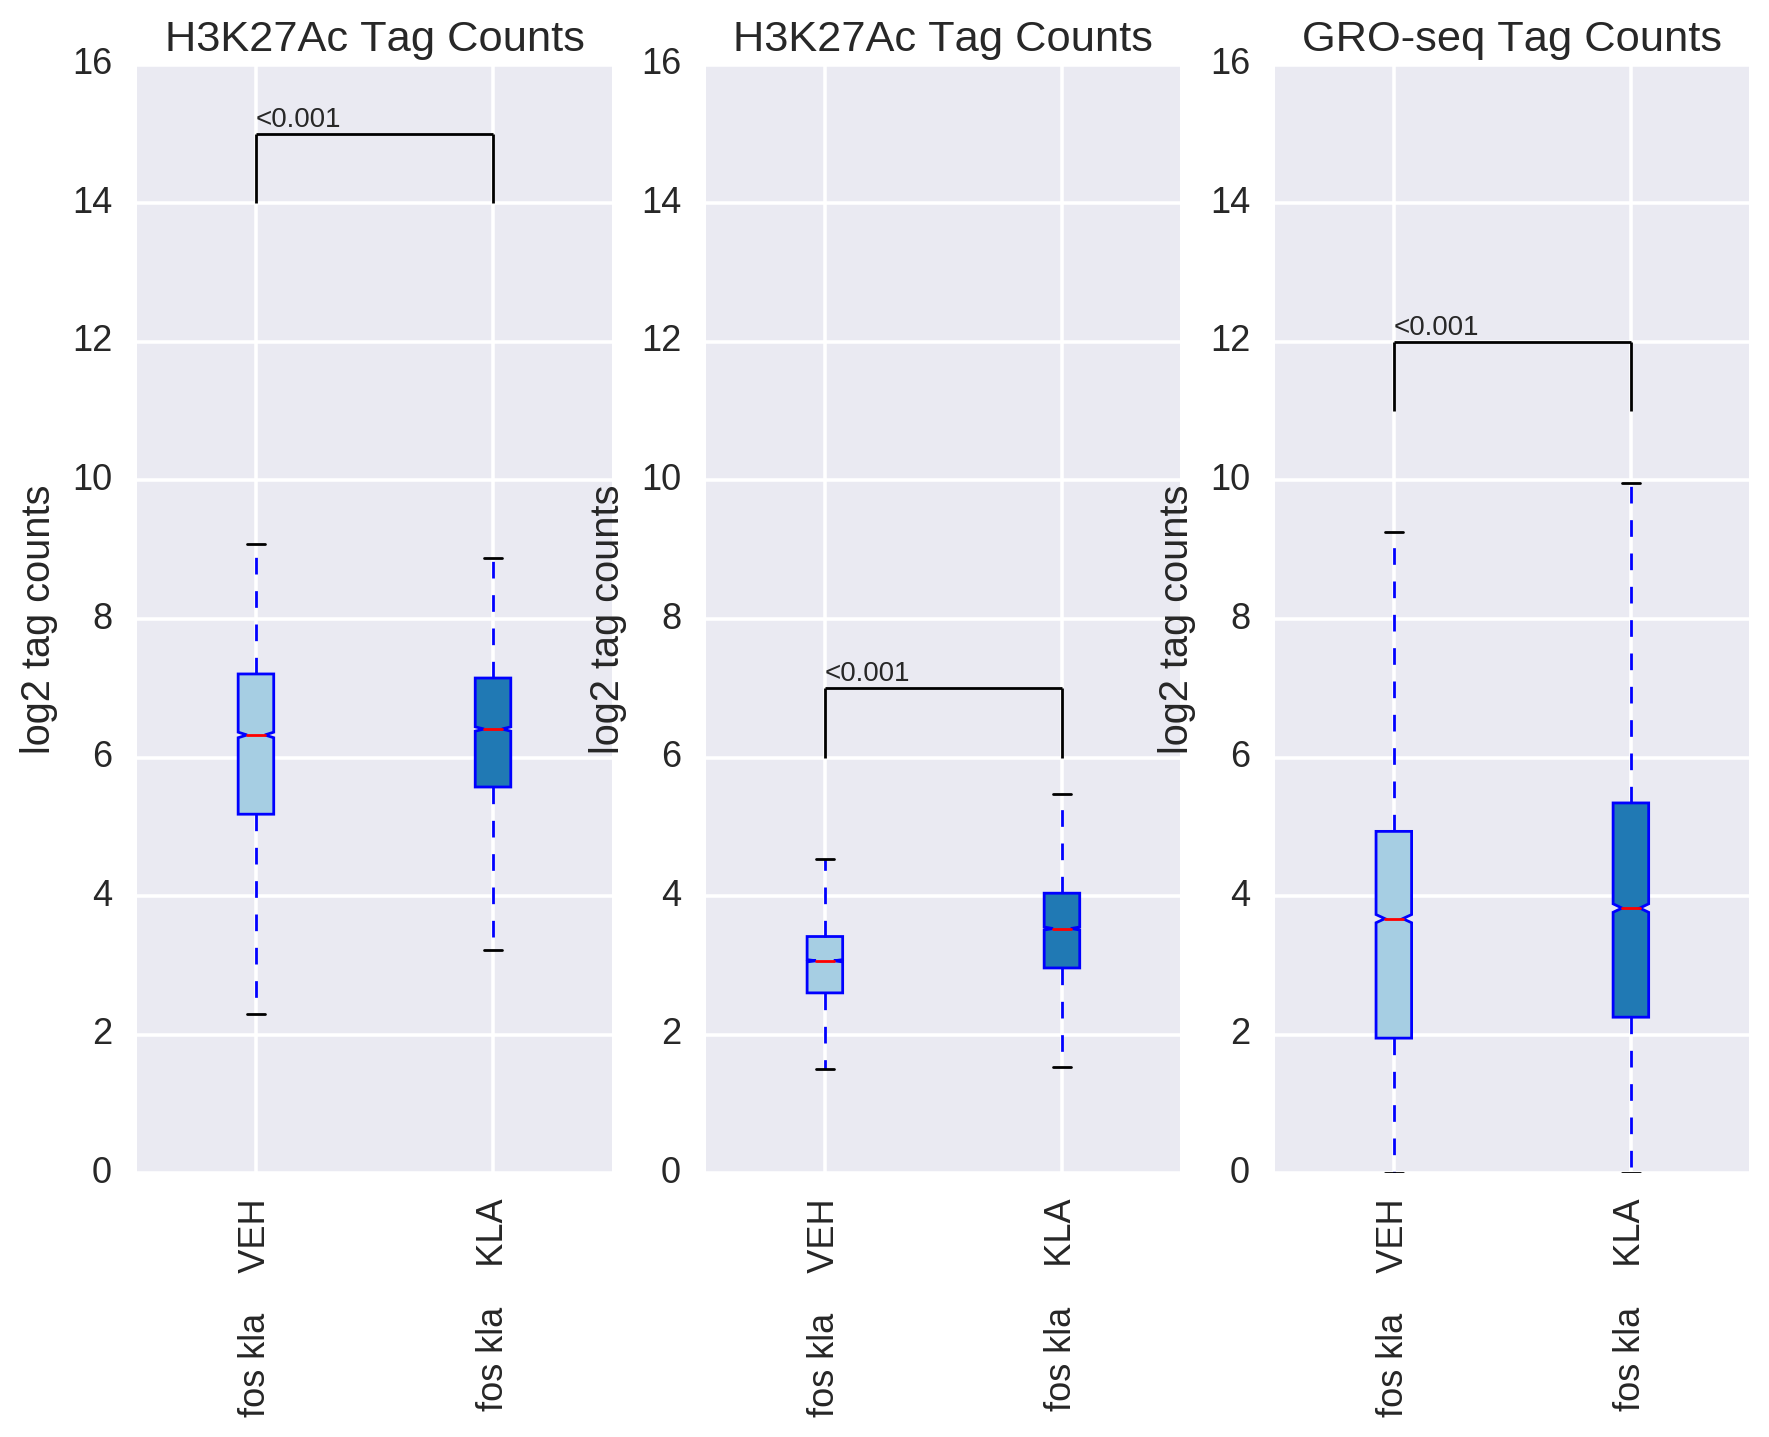

In [26]:
fos_collaborating_ids = summary_frame[(summary_frame.sum(axis=1)!=summary_frame['fos_kla']) & (summary_frame['fos_kla'] > 0)]['ID'].values

counts = []
labels = []
pvals = []
plt.subplot(1,3,1)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k27ac_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')



counts = []
labels = []
pvals = []
plt.subplot(1,3,2)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'h3k4me1_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')


counts = []
labels = []
pvals = []
plt.subplot(1,3,3)
veh_values = enhancer_frame.ix[fos_collaborating_ids,'gro_veh'].values
kla_values = enhancer_frame.ix[fos_collaborating_ids,'gro_kla'].values
veh_values = np.log2(veh_values + 1)
kla_values = np.log2(kla_values + 1)

if np.sum(veh_values) > 0 or np.sum(kla_values) > 0 :
    labels.append('fos kla    VEH')
    labels.append('fos kla    KLA')
    counts.append(veh_values)
    counts.append(kla_values)
    stat, p = scipy.stats.ttest_ind(veh_values,kla_values)
    pvals.append(p)

    box = plt.boxplot(counts, notch=True, patch_artist=True);
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    # annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,16])
plt.ylabel('log2 tag counts')
plt.title('GRO-seq Tag Counts')



## Strains Peak Files Calling 